<a href="https://colab.research.google.com/github/Thanos002/IL_Measurement/blob/main/IL_Data_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import aiohttp
import asyncio
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
import time
import traceback
import asyncio
import pandas as pd
from aiohttp import ClientError, ClientTimeout, ClientSession
from gql.transport.aiohttp import AIOHTTPTransport
from gql import Client, gql
from gql.transport.exceptions import TransportServerError
import datetime
import pickle

In [2]:
class Token:
  def __init__(self, name, id, type, decimals):
    self.name = name
    self.id = id
    self.type = type
    self.decimals = decimals

class Pool:
  def __init__(self, id, fee, token0, token1):
    self.id = id
    self.group = token0.type + "/" + token1.type
    self.name = token0.name + "_" + token1.name + "_" + str(fee)
    self.fee = fee
    self.token0 = token0
    self.token1 = token1

class PoolContainer:
    def __init__(self):
        self.pools = []

    def add_pool(self, pool):
        self.pools.append(pool)

    def __iter__(self):
        return iter(self.pools)
    

#Tokens
dai = Token("DAI","0x6b175474e89094c44da98b954eedeac495271d0f", "stable", 18)
usdc = Token("USDC", "0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48", "stable", 6)
weth = Token("WETH","0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2", "risky", 18)
mkr = Token("MKR","0x9f8f72aa9304c8b593d555f12ef6589cc3a579a2", "risky", 18)
wbtc = Token("WBTC","0x2260fac5e5542a773aa44fbcfedf7c193bc2c599", "risky", 8)

id2tokenObj = {
  dai.id: dai,
  usdc.id: usdc,
  weth.id: weth,
  mkr.id: mkr,
  wbtc.id: wbtc
}
   

# Stable pools:
dai_usdc_500 = Pool("0x6c6bc977e13df9b0de53b251522280bb72383700", 500, dai, usdc)
dai_usdc_100 = Pool("0x5777d92f208679db4b9778590fa3cab3ac9e2168", 100, dai, usdc)

# Stable-risky pools
usdc_weth_10000 = Pool("0x7bea39867e4169dbe237d55c8242a8f2fcdcc387", 10000, usdc, weth)
usdc_weth_3000 = Pool("0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8", 3000, usdc, weth)
usdc_weth_500 = Pool("0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640", 500, usdc, weth)
usdc_weth_100 = Pool("0xe0554a476a092703abdb3ef35c80e0d76d32939f", 100, usdc, weth)

#Risky pools
mkr_weth_10000 = Pool("0x3afdc5e6dfc0b0a507a8e023c9dce2cafc310316", 10000, mkr, weth)
wbtc_weth_3000 = Pool("0xcbcdf9626bc03e24f779434178a73a0b4bad62ed", 3000, wbtc, weth)
wbtc_weth_500 = Pool("0x4585fe77225b41b697c938b018e2ac67ac5a20c0", 500, wbtc, weth)


pools_container = PoolContainer()
pools_container.add_pool(dai_usdc_500)
pools_container.add_pool(dai_usdc_100)
pools_container.add_pool(usdc_weth_10000)
pools_container.add_pool(usdc_weth_3000)
pools_container.add_pool(usdc_weth_500)
pools_container.add_pool(usdc_weth_100)
pools_container.add_pool(mkr_weth_10000)
pools_container.add_pool(wbtc_weth_3000)
pools_container.add_pool(wbtc_weth_500)

for pools in pools_container:
  print(pools.name)


DAI_USDC_500
DAI_USDC_100
USDC_WETH_10000
USDC_WETH_3000
USDC_WETH_500
USDC_WETH_100
MKR_WETH_10000
WBTC_WETH_3000
WBTC_WETH_500


In [3]:
# Query request for fetching all the position snapshots
def build_query_ids(id, skip):
    begin_block = 14691320  # May 1st 2022
    end_block = 19560244  # April 1st 2024
    query = """
    {{
        positionSnapshots(
            where: {{pool_: {{id: "{}"}}, blockNumber_gte: "{}", blockNumber_lte: "{}", liquidity: "0"}}
            first: 1000
            skip: {}
        ) {{
            position {{
                id
            }}
        }}
    }}
    """
    return str(query.format(id, begin_block, end_block, skip))



In [4]:
def build_query_price(tokenID, timeInHoursAfterEpoch):
    query = """
    {{
        tokenHourData(id: "{}-{}") {{
            priceUSD
        }}
    }}
    
    """
    return gql(query.format(tokenID, timeInHoursAfterEpoch))

In [5]:
def build_query_positions(id):
  query = """
  query MyQuery {{
    positionSnapshots(
      where: {{position_: {{id: "{}"}}}}) {{
      blockNumber
      collectedFeesToken0
      collectedFeesToken1
      depositedToken0
      depositedToken1
      id
      liquidity
      owner
      pool {{
        id
      }}
      position {{
        amountCollectedUSD
        amountDepositedUSD
        amountWithdrawnUSD
        collectedFeesToken0
        collectedFeesToken1
        collectedToken0
        collectedToken1
        depositedToken0
        depositedToken1
        id
        liquidity
        tickLower
        tickUpper
        token0 {{
          id
        }}
        token1 {{
          id
        }}
        withdrawnToken0
        withdrawnToken1
      }}
      withdrawnToken0
      withdrawnToken1
      transaction {{
        blockNumber
        burns {{
          amount
          amount0
          amount1
          amountUSD
          timestamp
        }}
        collects {{
          amount0
          amount1
          amountUSD
          timestamp
        }}
        mints {{
          amount
          amount0
          amount1
          amountUSD
          timestamp
        }}
      }}
    }}
  }}"""
  return gql(query.format(id))

In [6]:
import pandas as pd
import csv
import pickle

def Extract_data(pool:Pool):
  url = 'https://api.thegraph.com/subgraphs/name/revert-finance/uniswap-v3-mainnet'
  id = pool.id
  frames = []
  skip = 0
  allfound = False
  while not allfound:
    tmp_query = build_query_ids(id, skip)
    r = requests.post(url, json={'query': tmp_query})
    json_data = json.loads(r.text)
    skip += 1000
    try:
      df_data = json_data['data']["positionSnapshots"]
      df = pd.DataFrame(df_data)
      frames.append(df)
      if len(df_data) < 1000:
        allfound = True
    except KeyError:
      break
  
  if frames:
    result = pd.concat(frames)
    result = result['position'].apply(lambda x: x['id'])
    result = result.astype(int)
    # Export result to csv with pool name in title
    # result.to_csv(f'{pool.name}_position_ids.csv')
    return result
  else:
    print("No data found for pool: ", pool.name)
    return pd.DataFrame()

pool_id_database = {}

# check if pickle file exists
try:
  with open('pool_id_database.pkl', 'rb') as f:
    pool_id_database = pickle.load(f)
  print("Data loaded from 'pool_id_database.pkl'.")
except FileNotFoundError:
  print("No existing data found. Fetching data from the API...")

  # Iterate through the pool objects in pools_container
  for pool in pools_container:
    pool_id_database[pool.name] = Extract_data(pool)
    
  csv_file = 'pool_id_database.csv'

  # Writing the dictionary to a CSV file
  with open(csv_file, mode='w', newline='') as file:
      writer = csv.writer(file)
      writer.writerow(['Pool Name', 'Position IDs'])
      for pool_name, ids in pool_id_database.items():
          writer.writerow([pool_name, ','.join(map(str, ids))])

  print(f"Data exported to '{csv_file}'.")

  with open('pool_id_database.pkl', 'wb') as f:
      pickle.dump(pool_id_database, f)
  print("Data exported to 'pool_id_database.pkl'.")


Data loaded from 'pool_id_database.pkl'.


In [7]:
pool_id_database

{'DAI_USDC_500': 0      102244
 1      102905
 2      106475
 3      107633
 4      109220
         ...  
 379     97641
 380      9812
 381     98439
 382      9849
 383     98875
 Name: position, Length: 384, dtype: int32,
 'DAI_USDC_100': 0      155816
 1      155929
 2      156278
 3      159842
 4      160680
         ...  
 736    695165
 737    696819
 738    697107
 739    697301
 740    699309
 Name: position, Length: 741, dtype: int32,
 'USDC_WETH_10000': 0       10975
 1      119141
 2      145558
 3      150411
 4        1571
         ...  
 635    692271
 636    694501
 637    698826
 638     70150
 639     70578
 Name: position, Length: 640, dtype: int32,
 'USDC_WETH_3000': 0      100030
 1       10038
 2      101078
 3      101736
 4       10184
         ...  
 995    261253
 996    261267
 997    261284
 998    261290
 999    261291
 Name: position, Length: 6000, dtype: int32,
 'USDC_WETH_500': 0      101394
 1      102011
 2      104854
 3      105327
 4      106726
  

In [8]:
import asyncio
from gql import Client, gql
from gql.transport.aiohttp import AIOHTTPTransport
from gql.transport.exceptions import TransportServerError
from aiohttp import ClientError
from pandas import json_normalize

def run_async_code(coroutine):
    loop = asyncio.get_event_loop()
    if loop.is_running():
        return asyncio.ensure_future(coroutine)
    else:
        return loop.run_until_complete(coroutine)

url_revert = 'https://api.thegraph.com/subgraphs/name/revert-finance/uniswap-v3-mainnet'
url_uniswap = 'https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3'

async def Extract_Position_data(ids):
    results = []
    # Use semaphore to limit number of concurrent connections
    semaphore = asyncio.Semaphore(10)
    async def fetch_data(id):
        retries = 5
        for attempt in range(retries):
            async with semaphore:
                transport = AIOHTTPTransport(url=url_revert)
                try:
                    async with Client(transport=transport, fetch_schema_from_transport=True, execute_timeout=30) as session:
                        query = build_query_positions(id)
                        response = await session.execute(query)
                        print("Extracted ID:" + str(id))
                        return pd.DataFrame(response['positionSnapshots'])
                except (ClientError, TimeoutError, TransportServerError) as e:
                    print(f"Error ({type(e).__name__}) for tokenID {id}: {str(e)}")
                    if attempt < retries - 1:
                        await asyncio.sleep(2 ** attempt)  # Exponential backoff
                        continue
                    else:
                        print(f"Failed to fetch data for ID {id} after {retries} attempts")
                except Exception as e:
                    print(f"Error ({type(e).__name__}) for tokenID {id}: {str(e)}")
                finally:
                    await transport.close()

    # Gather tasks with a new transport for each
    tasks = [fetch_data(id) for id in ids]
    results = await asyncio.gather(*tasks, return_exceptions=False)
    return results


async def Extract_Price_data(queueArray):
    results = []
    # Use semaphore to limit number of concurrent connections
    semaphore = asyncio.Semaphore(10)
    async def fetch_data(tokenID, timeInHoursAfterEpoch):
        retries = 5
        for attempt in range(retries):
            async with semaphore:
                transport = AIOHTTPTransport(url=url_uniswap)
                try:
                    async with Client(transport=transport, fetch_schema_from_transport=True, execute_timeout=30) as session:
                        timeInHoursAfterEpoch = int(timeInHoursAfterEpoch) # make sure value is int
                        query = build_query_price(tokenID, timeInHoursAfterEpoch)
                        print(tokenID, timeInHoursAfterEpoch)
                        response = await session.execute(query)
                        print("Extracted ID:" + str(tokenID))
                        if response['tokenHourData'] is None or pd.isna(response['tokenHourData']):
                            print(f"No data found for tokenID {tokenID} at timestamp {timeInHoursAfterEpoch}")
                            await asyncio.sleep(2 ** attempt)  # Exponential backoff
                            continue
                        print(response)
                        rounded_price = round(float(response['tokenHourData']['priceUSD']), 4)
                        return pd.DataFrame(
                            {'priceUSD': [rounded_price],
                            'tokenID': [tokenID],
                            'timestamp': [timeInHoursAfterEpoch]})
                except (ClientError, TimeoutError, TransportServerError) as e:
                    print(f"Error ({type(e).__name__}) for tokenID {tokenID}: {str(e)}")
                    if attempt < retries - 1:
                        await asyncio.sleep(2 ** attempt)  # Exponential backoff
                        continue
                    else:
                        print(f"Failed to fetch data for ID {tokenID} after {retries} attempts")
                except Exception as e:
                    print(f"Error ({type(e).__name__}) for tokenID {tokenID}: {str(e)}")
                finally:
                    await transport.close()

    # Gather tasks with a new transport for each
    token_ids, timestamps = queueArray

    tasks = [fetch_data(token_id, timestamp) for token_id in token_ids for timestamp in timestamps]

    results = await asyncio.gather(*tasks, return_exceptions=False)
    data_frames = [result for result in results if result is not None and not result.empty]
    final_df = pd.concat(data_frames, ignore_index=True)

    # Set 'tokenID' and 'timestamp' as the index
    final_df.set_index(['tokenID', 'timestamp'], inplace=True)

    return final_df

"""
result = await Extract_Position_data([40149])
print(result[0])

queueArray = [['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'], [450872, 451071, 450873]]
prices = await Extract_Price_data(queueArray)
print(prices)
"""

"\nresult = await Extract_Position_data([40149])\nprint(result[0])\n\nqueueArray = [['0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2', '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48'], [450872, 451071, 450873]]\nprices = await Extract_Price_data(queueArray)\nprint(prices)\n"

In [9]:
def run_async_code(coroutine):
    loop = asyncio.get_event_loop()
    if loop.is_running():
        return asyncio.ensure_future(coroutine)
    else:
        return loop.run_until_complete(coroutine)

def build_query_pools(pool_id, date):
    query = """
    {{
      poolDayData(id: "{}-{}") {{
        date
        txCount
        tvlUSD
        token0Price
        token1Price
        feesUSD
        volumeUSD
      }}
    }}
    """
    return gql(query.format(pool_id, date))

date_begin = datetime.datetime(2022, 5, 1)
date_end = datetime.datetime(2024, 4, 1)
epoch = datetime.datetime(1970, 1, 1)
days_since_epoch_begin = (date_begin - epoch).days
days_since_epoch_end = (date_end - epoch).days
print(days_since_epoch_begin, days_since_epoch_end)

async def Extract_Pool_data(ids, dates, url_uniswap):
    semaphore = asyncio.Semaphore(50)

    async def fetch_data(id, date):
        retries = 5
        transport = AIOHTTPTransport(url=url_uniswap)
        for attempt in range(retries):
            async with semaphore:
                try:
                    async with Client(transport=transport, fetch_schema_from_transport=True, execute_timeout=30) as session:
                        query = build_query_pools(id, date)
                        response = await session.execute(query)
                        print(f"Extracted ID: {id} for date: {date}")
                        if response.get('poolDayData'):
                            data = response['poolDayData']
                            return pd.DataFrame([{
                                'date': date,
                                'txCount': data['txCount'],
                                'tvlUSD': round(int(float(data['tvlUSD']))),
                                'token0Price': round(float(data['token0Price']), 4),
                                'token1Price': round(float(data['token1Price']), 4),
                                'feesUSD': round(float(data['feesUSD']), 4),
                                'volumeUSD': round(float(data['volumeUSD']), 4)
                            }])
                        return pd.DataFrame()
                except (ClientError, asyncio.TimeoutError, TransportServerError) as e:
                    print(f"Error ({type(e).__name__}) for tokenID {id} on date {date}: {str(e)}")
                    if attempt < retries - 1:
                        await asyncio.sleep(2 ** attempt)
                        continue
                    else:
                        print(f"Failed to fetch data for ID {id} after {retries} attempts on date {date}")
                except Exception as e:
                    print(f"Error ({type(e).__name__}) for tokenID {id} on date {date}: {str(e)}")
        return pd.DataFrame()

    tasks = [fetch_data(id, date) for id in ids for date in dates]
    results = await asyncio.gather(*tasks, return_exceptions=False)
    return results

async def get_pool_TVL(pools_container, days_since_epoch_begin, days_since_epoch_end, url_uniswap):
    pool_data_dict = {}
    dates = range(days_since_epoch_begin, days_since_epoch_end)
    
    for pool in pools_container:
        pool_TVL_df = pd.DataFrame()
        print(f"Processing pool: {pool.name}")
        results = await Extract_Pool_data([pool.id], dates, url_uniswap)
        
        for result in results:
            if not result.empty:
                pool_TVL_df = pd.concat([pool_TVL_df, result], ignore_index=True)
        
        pool_data_dict[pool.name] = pool_TVL_df
        print(f"Data for pool {pool.name}:")
        print(pool_TVL_df.head())

    with open('pool_data_TVL.pkl', 'wb') as f:
        pickle.dump(pool_data_dict, f)
        
    return pool_data_dict

try:
    with open('pool_data_TVL.pkl', 'rb') as f:
        pool_data = pickle.load(f)
        print("Loaded pool data from file.")
except FileNotFoundError:
    print("Pool data file not found, fetching data...")
    pool_data = run_async_code(get_pool_TVL(pools_container, days_since_epoch_begin, days_since_epoch_end, url_uniswap))
    print("Fetched pool data.")

19113 19814
Loaded pool data from file.


In [18]:
pool_data

{'DAI_USDC_500':       date txCount    tvlUSD  token0Price  token1Price    feesUSD  \
 0    19113      23  56946788       0.9999       1.0001   589.7570   
 1    19114      24  56947076       0.9999       1.0001   366.9308   
 2    19115      24  56947171       0.9999       1.0001    99.8041   
 3    19116      32  56947345       0.9999       1.0001   156.0406   
 4    19117      38  56948595       0.9999       1.0001  1289.5004   
 ..     ...     ...       ...          ...          ...        ...   
 695  19808       3  26913805       0.9998       1.0002    84.9878   
 696  19809       6  26913897       0.9998       1.0002   138.1343   
 697  19810       6  26913964       0.9998       1.0002    90.1885   
 698  19811       4  26913571       0.9998       1.0002     1.4366   
 699  19813       3  26913616       0.9998       1.0002    55.5976   
 
         volumeUSD  
 0    1.179514e+06  
 1    7.338616e+05  
 2    1.996081e+05  
 3    3.120812e+05  
 4    2.579001e+06  
 ..            .

In [11]:
from pandas import json_normalize
import numpy as np

priceQueue = []

def normalize_df_query(df):
    try:
        if df.empty:
            print("Dataframe is empty")
            return df

        global priceQueue

        df_normalized_positions = json_normalize(df['position'])
        df_normalized_positions = df_normalized_positions.add_prefix('position_')
        df = df.drop('position', axis=1).join(df_normalized_positions)
        
        df_normalized_pool = json_normalize(df['pool'])
        df_normalized_pool = df_normalized_pool.add_prefix('pool_')
        df = df.drop('pool', axis=1).join(df_normalized_pool)
        
        df_normalized_transaction = json_normalize(df['transaction'])
        df_normalized_transaction = df_normalized_transaction.add_prefix('transaction_')
        df = df.drop('transaction', axis=1).join(df_normalized_transaction)

        # Conditions to check for the presence of each event type
                
        conditions = [
            df['transaction_mints'].apply(lambda x: len(x) > 0),
            df['transaction_burns'].apply(lambda x: len(x) > 0),
            df['transaction_collects'].apply(lambda x: len(x) > 0)
        ]

        # Column names to use as values if conditions are met
        choices = ['mint', 'burn', 'collect']

        # Applying np.select to set the new column based on the first met condition
        df['eventType'] = np.select(conditions, choices, default='None')

        event = pd.DataFrame()

        for index, row in df.iterrows():
            if row['eventType'] == 'mint':
                temp_df = json_normalize(row['transaction_mints'])
                temp_df = temp_df.add_prefix('event_')
                event = pd.concat([event, temp_df], ignore_index=True)
            elif row['eventType'] == 'burn':
                temp_df = json_normalize(row['transaction_burns'])
                temp_df = temp_df.add_prefix('event_')
                if(len(temp_df) >= 2):
                    temp_df['event_amountUSD'] = temp_df['event_amountUSD'].astype(float) # Convert 'event_amountUSD' to float for filtering
                    temp_df = temp_df[temp_df['event_amountUSD'].notna() & (temp_df['event_amountUSD'] != 0)] # Filter out rows where 'event_amountUSD' are either zero or NaN
                if (len(row['transaction_collects']) > 0):
                    print("Collect event found in burn")
                    temp_collect = json_normalize(row['transaction_collects'])
                    temp_collect = temp_collect.add_prefix('collect_')
                    combined_df = pd.concat([temp_df, temp_collect], axis=1) # adding columns from collect event to burn event
                    combined_df['collect_amount0'] = combined_df['collect_amount0'].astype(float)
                    combined_df['collect_amount1'] = combined_df['collect_amount1'].astype(float)
                    combined_df['collect_amountUSD'] = combined_df['collect_amountUSD'].astype(float)
                else:
                    combined_df = temp_df
                event = pd.concat([event, combined_df], ignore_index=True)

            elif row['eventType'] == 'collect':
                temp_df = json_normalize(row['transaction_collects'])
                temp_df = temp_df.add_prefix('event_')
                event = pd.concat([event, temp_df], ignore_index=True)
            else:
                print("Error: No event type found")
                df.drop(index, inplace=True)
                #delete rows, event column does not exist

        df.fillna(0, inplace=True)
        event.fillna(0, inplace=True)
        event.reset_index(drop=True, inplace=True)     
        df.reset_index(drop=True, inplace=True)

        # set data types for the columns
        event['event_amountUSD'] = event['event_amountUSD'].astype(float)
        event['event_amount0'] = event['event_amount0'].astype(float)
        event['event_amount1'] = event['event_amount1'].astype(float)
        event['event_amount'] = event['event_amount'].astype(float)
        event['event_timestamp'] = event['event_timestamp'].astype(int)
        df['blockNumber'] = df['blockNumber'].astype(int)
        df['collectedFeesToken0'] = df['collectedFeesToken0'].astype(float)
        df['collectedFeesToken1'] = df['collectedFeesToken1'].astype(float)
        df['position_amountCollectedUSD'] = df['position_amountCollectedUSD'].astype(float)
        df['position_amountDepositedUSD'] = df['position_amountDepositedUSD'].astype(float)
        df['position_amountWithdrawnUSD'] = df['position_amountWithdrawnUSD'].astype(float)
        df['position_tickLower'] = df['position_tickLower'].astype(int)
        df['position_tickUpper'] = df['position_tickUpper'].astype(int)

        # Remove all rows with 0 or nan in 'event_amountUSD' and 'collect_amountUSD'
        # Filter out rows where 'event_amountUSD' are either zero or NaN
        #event = event[(event['event_amountUSD'] != 0) & (event['event_amountUSD'].notna())]


        priceQueue.append((df['position_token0.id'].iloc[0], (event['event_timestamp']//3600).tolist()))

        #df = df.convert_dtypes()
        #event = event.convert_dtypes()

        df = pd.concat([df.drop(['transaction_burns', 'transaction_collects', 'transaction_mints'], axis=1), event], axis=1)

        return df
    
    except Exception as e:
        print(f"Error in normalizing DataFrame: {e}")
        traceback.print_exc()
        print(df.to_markdown())
        print(event.to_markdown())
        print(df['event_amountUSD'])
        return df

def tick2prices(tick, token0id, token1id):
    token0 = id2tokenObj[token0id]
    token1 = id2tokenObj[token1id]
    price0 = (1.0001 ** tick) / (10**(token1.decimals - token0.decimals))
    price1 = 1/price0
    return price0, price1

def calculations(df):

    # check if dataframe is empty
    if df.empty:
        print("Dataframe is empty")
        return df

    df['assignedLiq'] = 0.0
    df['assignedDetails'] = None 
    df['assignedDetails'] = df['assignedDetails'].apply(lambda x: [])
    df['initialValue'] = 0.0
    df['HODLValue'] = 0.0
    df['finalValue'] = 0.0
    df['event_fees0'] = 0.0
    df['event_fees1'] = 0.0
    df['event_feesUSD'] = 0.0
    df['lossVersusHODLFees'] = 0.0
    df['lossVersusHODLExact'] = 0.0
    df['lossVersusHODLEst'] = 0.0
    df['weightedDurationSeconds'] = 0.0
    df['IL_initial'] = 0.0
    df['IL_final'] = 0.0
    df['absolute_return'] = 0.0
    df['relative_return'] = 0.0
    df['IL_total_abs'] = 0.0
    df['IL_total_rel'] = 0.0
    df['IL_annualized'] = 0.0
    df['relativeBurnSize'] = 0.0
    df['priceQuotient'] = 0.0
    df['IL_formula'] = 0.0
    df['IL_formula_total'] = 0.0
    df['IL_annualized_total'] = 0.0
    df['price0_lower'] = 0.0
    df['price1_lower'] = 0.0
    df['price0_upper'] = 0.0
    df['price1_upper'] = 0.0
    df['IL_fees'] = 0.0
    df['average_mint_price0'] = 0.0
    df['average_mint_price1'] = 0.0
    df['priceQuotient0'] = 0.0
    df['priceQuotient1'] = 0.0
    df['IL_formula_annualized'] = 0.0
    outstanding_fees0 = 0.0
    outstanding_fees1 = 0.0
    outstanding_feesUSD = 0.0

    rows_to_drop = []

    for index, row in df.iterrows():

        try:

            df['event_fees0'] = df['event_fees0'].astype(float)
            df['event_fees1'] = df['event_fees1'].astype(float)
            df['event_feesUSD'] = df['event_feesUSD'].astype(float)

            # If both burn and collect are nan or 0
            if (pd.isna(row.get('event_amountUSD', float('nan'))) or row.get('event_amountUSD') == 0) and (pd.isna(row.get('collect_amountUSD', float('nan'))) or row.get('collect_amountUSD') == 0):
                rows_to_drop.append(index)
                print("Dropped row with no event amount and collect amount")
                continue

            # Special case: burn and collect event, zero burn, but labeled as burn, with collect amount
            if row['eventType'] == 'burn' and row.get('event_amountUSD') == 0 and 'collect_amountUSD' in row and not pd.isna(row.get('collect_amountUSD')) and row.get('collect_amountUSD') > 0:
                # drop burn event with 0 amount
                print("Dropped burn event with 0 amount, conserved fees")
                outstanding_fees0 += row.get('collect_amount0', 0.0)
                outstanding_fees1 += row.get('collect_amount1', 0.0)
                outstanding_feesUSD += row.get('collect_amountUSD', 0.0)
                rows_to_drop.append(index)
                #df.reset_index(drop=True, inplace=True)
                continue
            
            # Special case: pure collect event
            if row['eventType'] == 'collect':
                outstanding_fees0 += row['event_amount0']
                outstanding_fees1 += row['event_amount1']
                outstanding_feesUSD += row['event_amountUSD']
                # drop collect event
                rows_to_drop.append(index)
                #df.reset_index(drop=True, inplace=True)
                print("Dropped collect event")
                continue

            df['price_0'] = df['price_0'].astype(float)
            df['price_1'] = df['price_1'].astype(float)
            df['price0_lower'] = df['price0_lower'].astype(float)
            df['price1_lower'] = df['price1_lower'].astype(float)
            df['price0_upper'] = df['price0_upper'].astype(float)
            df['price1_upper'] = df['price1_upper'].astype(float)
            df['initialValue'] = df['initialValue'].astype(float)
            df['HODLValue'] = df['HODLValue'].astype(float)
            df['finalValue'] = df['finalValue'].astype(float)
            df['priceQuotient'] = df['priceQuotient'].astype(float)
            df['relativeBurnSize'] = df['relativeBurnSize'].astype(float)
            df['lossVersusHODLExact'] = df['lossVersusHODLExact'].astype(float)
            df['lossVersusHODLEst'] = df['lossVersusHODLEst'].astype(float)
            df['lossVersusHODLFees'] = df['lossVersusHODLFees'].astype(float)
            df['assignedLiq'] = df['assignedLiq'].astype(float)
            df['IL_initial'] = df['IL_initial'].astype(float)
            df['IL_final'] = df['IL_final'].astype(float)
            df['IL_fees'] = df['IL_fees'].astype(float)
            df['IL_annualized'] = df['IL_annualized'].astype(float)
            df['IL_total_abs'] = df['IL_total_abs'].astype(float)
            df['IL_total_rel'] = df['IL_total_rel'].astype(float)
            df['average_mint_price0'] = df['average_mint_price0'].astype(float)
            df['average_mint_price1'] = df['average_mint_price1'].astype(float)

            '''
            # Calculate event fees from total fees collected
            current_fees0 = row['collectedFeesToken0']
            current_fees1 = row['collectedFeesToken1']
            df.at[index, 'event_fees0'] = current_fees0 - prev_fees0
            df.at[index, 'event_fees1'] = current_fees1 - prev_fees1
            df.at[index, 'event_feesUSD'] = df.at[index, 'price_0'] * df.at[index, 'event_fees0'] + df.at[index, 'price_1'] * df.at[index, 'event_fees1']
            prev_fees0 = current_fees0
            prev_fees1 = current_fees1
            '''

            # transform tick values to prices for mint or burn events
            if row['eventType'] == 'mint' or row['eventType'] == 'burn':
                price_0, price_1 = tick2prices(row['position_tickLower'], row['position_token0.id'], row['position_token1.id'])
                df.at[index, 'price0_lower'] = price_0
                df.at[index, 'price1_upper'] = price_1
                price_0, price_1 = tick2prices(row['position_tickUpper'], row['position_token0.id'], row['position_token1.id'])
                df.at[index, 'price0_upper'] = price_0
                df.at[index, 'price1_lower'] = price_1

        except Exception as e:
            print("Assignment error: ", e)
            traceback.print_exc()
            print("Row: ", row.to_markdown())
            print("Index: ", index)
            print(df.at[index, 'event_amountUSD'])
            print(df.to_markdown())

        if row['eventType'] == 'burn' and index not in rows_to_drop:

            # Explaination: Fees are either in collect event paired with burn evnet or in pure collect event -> outstanding_fees
            
            # Updated fee calculation based on collect event with every burn event
            if 'collect_amountUSD' in row and not pd.isna(row['collect_amountUSD']):
                df.at[index, 'event_fees0'] =  df.at[index, 'collect_amount0'] - df.at[index, 'event_amount0'] + outstanding_fees0
                df.at[index, 'event_fees1'] =  df.at[index, 'collect_amount1'] - df.at[index, 'event_amount1'] + outstanding_fees1
                df.at[index, 'event_feesUSD'] = df.at[index, 'collect_amountUSD'] - df.at[index, 'event_amountUSD'] + outstanding_feesUSD # 2* because fees are substracted with event_amountUSD
            else:
                df.at[index, 'event_fees0'] += outstanding_fees0
                df.at[index, 'event_fees1'] += outstanding_fees1
                df.at[index, 'event_feesUSD'] += outstanding_feesUSD
            
            burn_liq_needed = row['event_amount']
            # reset outstanding fees
            outstanding_fees0 = 0.0
            outstanding_fees1 = 0.0
            outstanding_feesUSD = 0.0
            initial_value_sum = 0.0
            hodl_value_sum = 0.0
            time_wighted_sum = 0.0
            total_assigned_liquidity = 0.0
            burn_timestamp = row['event_timestamp']

            try:

                for i in range(0, index):

                    if df.at[i, 'eventType'] == 'mint' and df.at[i, 'assignedLiq'] < df.at[i, 'event_amount']: # Check if liquidity is available to assign
                        mint_avail = df.at[i, 'event_amount'] - df.at[i, 'assignedLiq']
                        assigned_liq = min(mint_avail, burn_liq_needed)
                        mint_price_0 = df.at[i, 'price_0']
                        mint_price_1 = df.at[i, 'price_1']
                        mint_assigned_amount0 = df.at[i, 'event_amount0'] * (assigned_liq / df.at[i, 'event_amount'])
                        mint_assigned_amount1 = df.at[i, 'event_amount1'] * (assigned_liq / df.at[i, 'event_amount'])

                        # Calculate duration of liquidity provision in hours
                        mint_timestamp = df.at[i, 'event_timestamp']
                        duration = (burn_timestamp - mint_timestamp)
                        time_wighted_sum += duration * assigned_liq
                        total_assigned_liquidity += assigned_liq

                        # Initial value calculation using Mint prices and assigned amounts
                        initial_value = mint_price_0 * mint_assigned_amount0 + mint_price_1 * mint_assigned_amount1
                        initial_value_sum += initial_value

                        weighted_mint_price0_sum = mint_price_0 * assigned_liq
                        weighted_mint_price1_sum = mint_price_1 * assigned_liq
                        
                        # HODL value calculation using Burn prices and the same assigned amounts
                        hodl_value = row['price_0'] * mint_assigned_amount0 + row['price_1'] * mint_assigned_amount1
                        hodl_value_sum += hodl_value

                        # Assign liquidity to the burn event
                        df.at[i, 'assignedLiq'] += assigned_liq
                        df.at[index, 'assignedLiq'] += assigned_liq
                        burn_liq_needed -= assigned_liq
                        df.at[index, 'assignedDetails'].append((i, assigned_liq))

                        print(f"Assigned liquidity: {assigned_liq} to mint event {i} from burn event {index}")
                        print(f"Assigned amount0: {mint_assigned_amount0}, Assigned amount1: {mint_assigned_amount1}")
                        print(f"Remaining liquidity needed: {burn_liq_needed}, mint liquidity available: {mint_avail}")

                        if burn_liq_needed == 0:
                            break
                
                if total_assigned_liquidity >0:
                    df.at[index, 'average_mint_price0'] = weighted_mint_price0_sum / total_assigned_liquidity
                    df.at[index, 'average_mint_price1'] = weighted_mint_price1_sum / total_assigned_liquidity

                # Calculate the IL metrics
                
                print("Metric calculations")
                print(df.to_markdown())
                print(f"Initial value sum: {initial_value_sum}")
                print("Total assigned liquidity: ", total_assigned_liquidity)
                print("Time weighted sum: ", time_wighted_sum)
                if total_assigned_liquidity > 0:
                    df.at[index, 'weightedDurationSeconds'] = time_wighted_sum / total_assigned_liquidity
                    print("Weighted duration: ", df.at[index, 'weightedDurationSeconds']) 
                df.at[index, 'initialValue'] = initial_value_sum
                df.at[index, 'HODLValue'] = hodl_value_sum
                df.at[index, 'finalValue'] = row['price_0'] * row['event_amount0'] + row['price_1'] * row['event_amount1']
                df.at[index, 'priceQuotient0'] = (df.at[index, 'price_0'] / df.at[index, 'price_1']) / (df.at[index, 'average_mint_price0'] / df.at[index, 'average_mint_price1']) # change of token0/token1 price ratio
                df.at[index, 'priceQuotient1'] = (df.at[index, 'price_1'] / df.at[index, 'price_0']) / (df.at[index, 'average_mint_price1'] / df.at[index, 'average_mint_price0']) # change of token1/token0 price ratio
                df.at[index, 'relativeBurnSize'] = df.at[index, 'event_amountUSD'] / df.at[index, 'position_amountWithdrawnUSD']
                df.at[index, 'lossVersusHODLExact'] = row['event_amountUSD'] - df.at[index, 'HODLValue']
                df.at[index, 'lossVersusHODLEst'] = df.at[index, 'finalValue'] - df.at[index, 'HODLValue']
                df.at[index, 'lossVersusHODLFees'] = df.at[index, 'lossVersusHODLExact'] + df.at[index, 'event_feesUSD']
                df.at[index, 'IL_initial'] = df.at[index, 'lossVersusHODLExact'] / df.at[index, 'initialValue']
                df.at[index, 'IL_final'] = df.at[index, 'lossVersusHODLExact'] / df.at[index, 'event_amountUSD']
                df.at[index, 'IL_fees'] = df.at[index, 'lossVersusHODLFees'] / df.at[index, 'event_amountUSD']
                df.at[index, 'IL_annualized'] = (df.at[index, 'IL_final']+1) ** (1/(df.at[index, 'weightedDurationSeconds']/3600/24/365.25)) - 1

                # choosing token1 als reference since token 0 is ususally the stablecoin
                pb = df.at[index, 'price1_upper']
                pa = df.at[index, 'price1_lower']
                d = df.at[index, 'priceQuotient1']
                p = df.at[index, 'average_mint_price1'] / df.at[index, 'average_mint_price0'] # initial price ratio of token1 in token0

                print(df.to_markdown())
                print(f"pa: {pa}, pb: {pb}, d: {d}, p: {p}")
                
                # Formula adapted from Hashemseresht, Pourpouneh, "Concentrated Liquidity Analysis in Uniswap V3", 2022

                if pb/p < d:
                    print("pb/p < d")
                    formula = (np.sqrt(pb/p)-d*(1-np.sqrt(p/pb))-1) / (d*(1-np.sqrt(p/pb))+1-np.sqrt(pa/p))
                elif pa/p <= d <= pb/p:
                    print("pa/p <= d <= pb/p")
                    formula = (2*np.sqrt(d)-1-d) / (1+d-np.sqrt(pa/p)-d*(np.sqrt(p/pb)))
                elif d < pa/p:
                    print("d < pa/p")
                    formula = (d*(np.sqrt(p/pa)-1)-1+np.sqrt(pa/p)) / (d*(1-np.sqrt(p/pb))+1-np.sqrt(pa/p))
                else:
                    print("Error in formula calculation")
                    formula = None

                df.at[index, 'IL_formula'] = formula

                if (formula is None or np.isnan(formula) or np.isinf(formula)):
                    print("Error in formula calculation")
                    return None

                # sometimes formula returns positive results for extremely low/high values
                if (formula > 0):
                    print("IL very close to 0, using IL final instead of formula")
                    df.at[index, 'IL_formula'] = df.at[index, 'IL_final']

                df.at[index, 'IL_formula_annualized'] = (df.at[index, 'IL_formula']+1) ** (1/(df.at[index, 'weightedDurationSeconds']/3600/24/365.25)) - 1

                print(f"IL_initial: {df.at[index, 'IL_initial']}, IL_final: {df.at[index, 'IL_final']}, IL_annualized: {df.at[index, 'IL_annualized']}, IL_formula: {df.at[index, 'IL_formula']}")
            
            except Exception as e:
                traceback.print_exc()
                print(f"Error in calculation: {e}")
                continue

    df.drop(index=rows_to_drop, inplace=True)
    df.reset_index(drop=True, inplace=True)

    df['absolute_return'] = df['position_amountCollectedUSD'] - df['position_amountDepositedUSD']
    df['relative_return'] = df['absolute_return'] / df['position_amountDepositedUSD']
    df['IL_total_abs'] = df['lossVersusHODLExact'].sum()
    df['IL_total_rel'] = df['IL_total_abs']/df['position_amountDepositedUSD']
    df['IL_annualized_total'] = (df['relativeBurnSize'] * df['IL_annualized']).sum()
    df['IL_formula_total'] = (df['relativeBurnSize'] * df['IL_formula']).sum()

    return df


def shorten_df(df):
    try:
        burns_only = df[df['eventType'] == 'burn']
        selected_columns = [
            'id', 'owner', 'pool_id', 'position_amountCollectedUSD',
            'position_amountDepositedUSD', 'position_amountWithdrawnUSD',
            'position_id', 'position_liquidity', 'position_withdrawnToken0',
            'position_withdrawnToken1', 'position_token0.id', 'position_token1.id',
            'event_amount', 'event_amount0', 'event_amount1', 'event_amountUSD', 'event_timestamp', 'price_0',
            'price_1', 'initialValue', 'HODLValue', 'finalValue', 'event_fees0', 'event_fees1',
            'lossVersusHODLFees', 'lossVersusHODLExact', 'lossVersusHODLEst',
            'weightedDurationSeconds', 'IL_initial', 'IL_final', 'absolute_return',
            'relative_return', 'IL_total_abs', 'IL_total_rel', 'IL_annualized',
            'relativeBurnSize', 'IL_formula', 'IL_formula_total',
            'IL_annualized_total', 'IL_fees', 'event_feesUSD', 'price0_lower', 'price1_lower',
            'price0_upper', 'price1_upper', 'IL_formula_annualized', 'average_mint_price0',
            'average_mint_price1', 'priceQuotient0', 'priceQuotient1'
        ]

        # Create a new DataFrame with only the columns we need
        result = burns_only[selected_columns].reset_index(drop=True)

        # Round the values to 6 decimal places
        result = result.round(6)
        
        return result
    except Exception as e:
        print(f"Error in shortening DataFrame: {e}")
        traceback.print_exc()
        return df

"""
res = result.copy()

# normalize all queried results
for i in range(len(res)):
    df = res[i]
    normalized_df = normalize_df_query(df)
    # Add prices to dataframe
    token_ids = [normalized_df['position_token0.id'].iloc[0], normalized_df['position_token1.id'].iloc[0]]
    timestamps = (normalized_df['event_timestamp']//3600).unique().tolist()
    queueArray = [token_ids, timestamps]
    extracted_prices = await Extract_Price_data(queueArray)
    
    # Merge the extracted prices with the normalized DataFrame
    for idx, token_id in enumerate(token_ids):
        price_col_name = f'price_{idx}'  # Use idx to differentiate price_0 and price_1
        prices = extracted_prices.xs(token_id, level='tokenID')['priceUSD']
        normalized_df[price_col_name] = normalized_df['event_timestamp']//3600
        normalized_df[price_col_name] = normalized_df[price_col_name].map(prices)

    calculations(normalized_df)
    print((normalized_df.to_string()))
    print(shorten_df(normalized_df).to_string())
    normalized_df.to_csv('normalized_df.csv')

"""

"\nres = result.copy()\n\n# normalize all queried results\nfor i in range(len(res)):\n    df = res[i]\n    normalized_df = normalize_df_query(df)\n    # Add prices to dataframe\n    token_ids = [normalized_df['position_token0.id'].iloc[0], normalized_df['position_token1.id'].iloc[0]]\n    timestamps = (normalized_df['event_timestamp']//3600).unique().tolist()\n    queueArray = [token_ids, timestamps]\n    extracted_prices = await Extract_Price_data(queueArray)\n    \n    # Merge the extracted prices with the normalized DataFrame\n    for idx, token_id in enumerate(token_ids):\n        price_col_name = f'price_{idx}'  # Use idx to differentiate price_0 and price_1\n        prices = extracted_prices.xs(token_id, level='tokenID')['priceUSD']\n        normalized_df[price_col_name] = normalized_df['event_timestamp']//3600\n        normalized_df[price_col_name] = normalized_df[price_col_name].map(prices)\n\n    calculations(normalized_df)\n    print((normalized_df.to_string()))\n    print(sh

In [12]:
shortened_pools = {key: value.head(100) for key, value in pool_id_database.items()}
print(shortened_pools)

{'DAI_USDC_500': 0     102244
1     102905
2     106475
3     107633
4     109220
       ...  
95    284490
96    284492
97    292398
98    292691
99    294349
Name: position, Length: 100, dtype: int32, 'DAI_USDC_100': 0     155816
1     155929
2     156278
3     159842
4     160680
       ...  
95    260813
96    261430
97    261566
98    261845
99    262471
Name: position, Length: 100, dtype: int32, 'USDC_WETH_10000': 0      10975
1     119141
2     145558
3     150411
4       1571
       ...  
95    251462
96    251514
97    251593
98    252046
99    252083
Name: position, Length: 100, dtype: int32, 'USDC_WETH_3000': 0     100030
1      10038
2     101078
3     101736
4      10184
       ...  
95     11203
96    112109
97    112215
98     11227
99    112416
Name: position, Length: 100, dtype: int32, 'USDC_WETH_500': 0     101394
1     102011
2     104854
3     105327
4     106726
       ...  
95    145806
96    145813
97    145815
98    146249
99    147176
Name: position, Length: 10

In [13]:
"""
for pool in pools_container:
  result = {}
  result[pool.name] = await Extract_Position_data(pool_id_database[pool.name])
  for i in range(len(result[pool.name])):
    result[pool.name][i] = normalize_df_query(result[pool.name][i])

"""
import os
import math

async def process_and_normalize_data(pool_id_database):
    # Create a dictionary to store the normalized dataframes for each pool
    normalized_dataframes = {}

    try:

        # Iterate over each pool and their corresponding IDs
        for pool_name, ids in pool_id_database.items():
            if ids.empty:
                print(f"No position IDs available for pool: {pool_name}")
                continue

            # if file exists, skip
            if os.path.exists(f"{pool_name}_normalized_data.csv"):
                print(f"Skipping pool: {pool_name}. Data already exists.")
                try:
                    with open(f"{pool_name}_normalized_dataframes.pkl", "rb") as f:
                        normalized_dataframes[pool_name] = pickle.load(f)
                        print(f"Data loaded from '{pool_name}_normalized_dataframes.pkl'.")
                    continue
                except FileNotFoundError:
                    print(f"File '{pool_name}_normalized_dataframes.pkl' not found. Processing data...")


            # Extract position data asynchronously
            position_dataframes = await Extract_Position_data(ids.tolist())
            print("Extracting Pool: " + str(pool_name))

            all_normalized_dfs = []

            # Normalize each dataframe obtained for the positions and add prices
            for df in position_dataframes:
                #if df empty, Delete the empty dataframe
                if df is None or df.empty:
                    position_dataframes.remove(df)
                    print("df empty")
                    continue
                normalized_df = normalize_df_query(df)
                # Add prices to dataframe

                token_ids = [normalized_df['position_token0.id'].iloc[0], normalized_df['position_token1.id'].iloc[0]]
                print(token_ids)

                if token_ids[0] is None or token_ids[1] is None:
                    print(f"Token ID not found for pool: {pool_name}")
                    position_dataframes.remove(df)
                    continue                
                
                fetch_token_ids = []
                for token_id in token_ids:
                    if token_id not in [dai.id, usdc.id]:
                        fetch_token_ids.append(token_id)
                              
                if fetch_token_ids:
                    timestamps = (normalized_df['event_timestamp']//3600).unique().tolist()
                    timestamps = [value for value in timestamps if not math.isnan(value) and value != 0]
                    print(timestamps)
                    queueArray = [fetch_token_ids, timestamps]
                    print(queueArray)
                    extracted_prices = await Extract_Price_data(queueArray)
                    if extracted_prices is None:
                        print(f"No price data found for token IDs after several retries: {fetch_token_ids}")
                        continue

                for idx, token_id in enumerate(token_ids):
                    price_col_name = f'price_{idx}'
                    if token_id in [dai.id, usdc.id]:
                        normalized_df[price_col_name] = 1.0
                    else:
                        prices = extracted_prices.xs(token_id, level='tokenID')['priceUSD']
                        normalized_df[price_col_name] = normalized_df['event_timestamp']//3600
                        print("Before map", normalized_df[price_col_name])
                        normalized_df[price_col_name] = normalized_df[price_col_name].map(prices)
                        print("After map:", normalized_df[price_col_name])
                    print(f"Prices added for token ID: {token_id}")


                print("Enter calculations")
                calculated_df = calculations(normalized_df)
                if calculated_df is None or calculated_df.empty:
                    print("Error: No data found after calculations")
                    continue
                print("Eneter shortening")
                shortened_df = shorten_df(calculated_df)
                
                all_normalized_dfs.append(shortened_df)

            # Concatenate all normalized dataframes for the current pool
            if all_normalized_dfs:
                final_normalized_df = pd.concat(all_normalized_dfs, ignore_index=True)
                normalized_dataframes[pool_name] = final_normalized_df

                # Save the concatenated DataFrame to a CSV file
                csv_filename = f"{pool_name}_normalized_data.csv"
                final_normalized_df.to_csv(csv_filename, index=False, sep=';', decimal=',')
                print(f"Data for {pool_name} saved to '{csv_filename}'.")
            else:
                print(f"No data found after normalization for pool: {pool_name}")

            with open(f"{pool_name}_normalized_dataframes.pkl", "wb") as f:
                pickle.dump(final_normalized_df, f)
                print("Data exported to 'normalized_dataframes.pkl'.")

        return normalized_dataframes
    
    except Exception as e:
        print(f"Error processing and normalizing data: {e}")
        traceback.print_exc()
        return None

# Example usage:
result = run_async_code(process_and_normalize_data(pool_id_database))
print(result)


<Task pending name='Task-5' coro=<process_and_normalize_data() running at C:\Users\thano\AppData\Local\Temp\ipykernel_71120\3634440302.py:12>>


In [14]:

dataframes = [df for df in result.result().values()]
pool_dataframes = result.result()

#remove zero amounts from pool_dataframes
for key, value in pool_dataframes.items():
  pool_dataframes[key] = value[(value['IL_final'] >= -1) & (value['IL_final'] <= 0) & (value['event_amountUSD'] != 0) & (value['IL_formula'] >= -1)]

combined_df = pd.concat(dataframes, ignore_index=True)
combined_df = combined_df[(combined_df['IL_final'] >= -1) & (combined_df['IL_final'] <= 0) & (combined_df['event_amountUSD'] != 0) & (combined_df['IL_formula'] >= -1)]

# Create pool set without stablecoin-stablecoin pools based on keys from the pool_dataframes dictionary
risky_pools = {key: value for key, value in pool_dataframes.items() if key not in ['DAI_USDC_500', 'DAI_USDC_100']}
risky_dataframes = [df for df in risky_pools.values()]
risky_combined_df = pd.concat(risky_dataframes, ignore_index=True)

Skipping pool: DAI_USDC_500. Data already exists.
Data loaded from 'DAI_USDC_500_normalized_dataframes.pkl'.
Skipping pool: DAI_USDC_100. Data already exists.
Data loaded from 'DAI_USDC_100_normalized_dataframes.pkl'.
Skipping pool: USDC_WETH_10000. Data already exists.
Data loaded from 'USDC_WETH_10000_normalized_dataframes.pkl'.
Skipping pool: USDC_WETH_3000. Data already exists.
Data loaded from 'USDC_WETH_3000_normalized_dataframes.pkl'.
Skipping pool: USDC_WETH_500. Data already exists.
Data loaded from 'USDC_WETH_500_normalized_dataframes.pkl'.
Skipping pool: USDC_WETH_100. Data already exists.
Data loaded from 'USDC_WETH_100_normalized_dataframes.pkl'.
Skipping pool: MKR_WETH_10000. Data already exists.
Data loaded from 'MKR_WETH_10000_normalized_dataframes.pkl'.
Skipping pool: WBTC_WETH_3000. Data already exists.
Data loaded from 'WBTC_WETH_3000_normalized_dataframes.pkl'.
Skipping pool: WBTC_WETH_500. Data already exists.
Data loaded from 'WBTC_WETH_500_normalized_dataframes.p

In [15]:
combined_df.columns

Index(['id', 'owner', 'pool_id', 'position_amountCollectedUSD',
       'position_amountDepositedUSD', 'position_amountWithdrawnUSD',
       'position_id', 'position_liquidity', 'position_withdrawnToken0',
       'position_withdrawnToken1', 'position_token0.id', 'position_token1.id',
       'event_amount', 'event_amount0', 'event_amount1', 'event_amountUSD',
       'event_timestamp', 'price_0', 'price_1', 'initialValue', 'HODLValue',
       'finalValue', 'event_fees0', 'event_fees1', 'lossVersusHODLFees',
       'lossVersusHODLExact', 'lossVersusHODLEst', 'weightedDurationSeconds',
       'IL_initial', 'IL_final', 'absolute_return', 'relative_return',
       'IL_total_abs', 'IL_total_rel', 'IL_annualized', 'relativeBurnSize',
       'IL_formula', 'IL_formula_total', 'IL_annualized_total', 'IL_fees',
       'event_feesUSD', 'price0_lower', 'price1_lower', 'price0_upper',
       'price1_upper', 'IL_formula_annualized', 'average_mint_price0',
       'average_mint_price1', 'priceQuotient0',

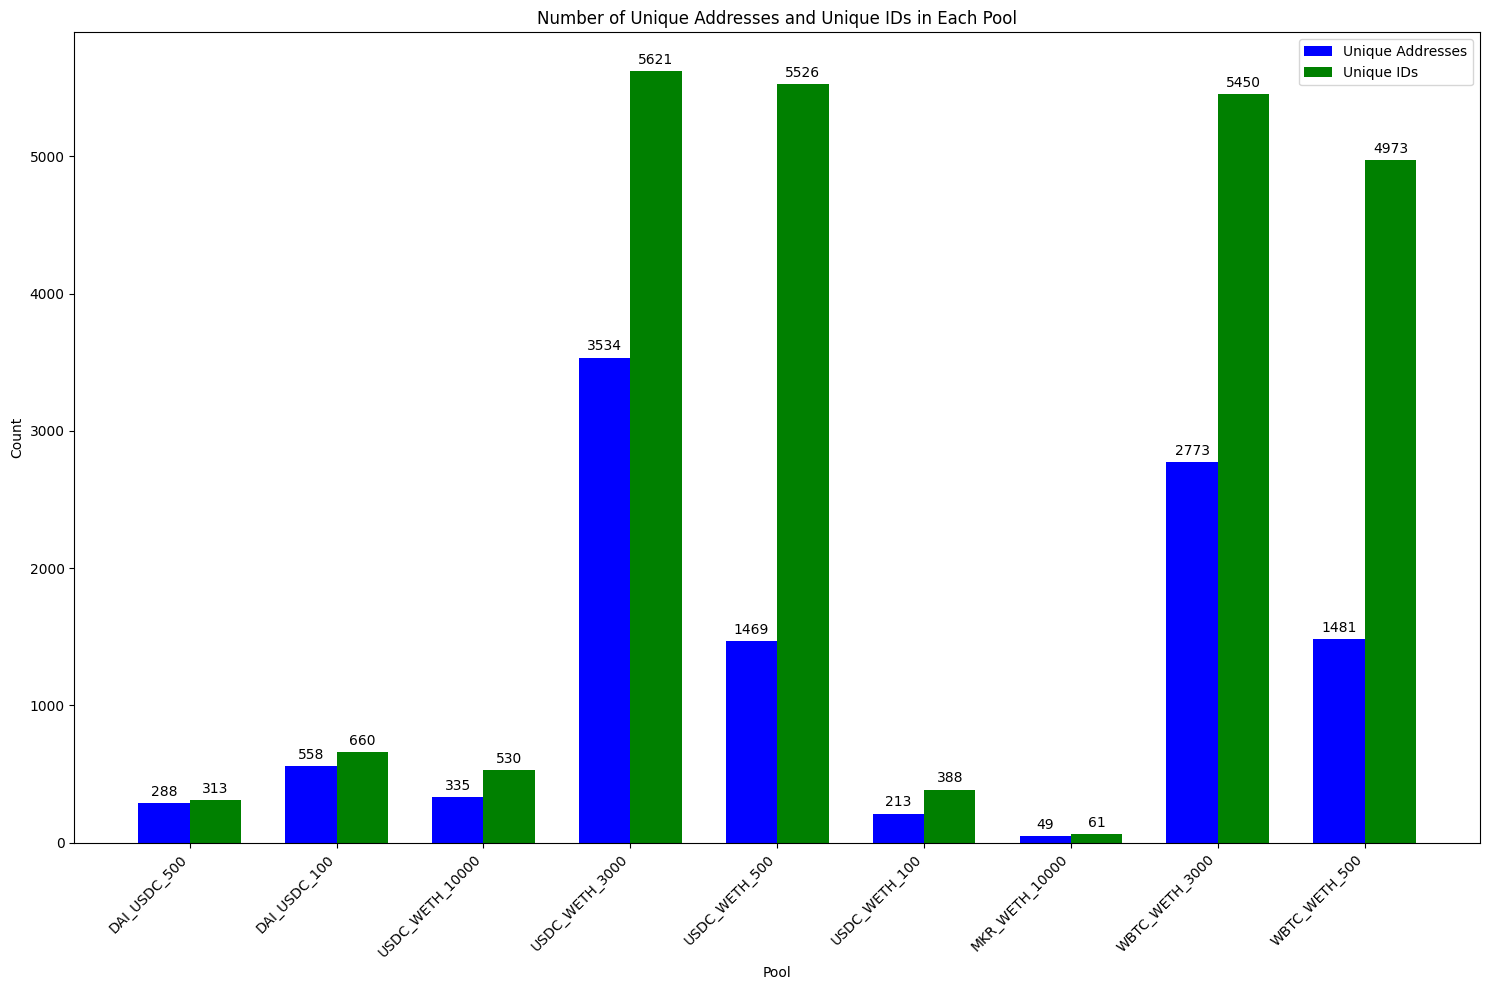

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming pool_dataframes has been preprocessed as described
# and contains the necessary filtered dataframes

# Get the unique address counts and unique ID counts for each pool
pool_names = []
unique_address_counts = []
unique_id_counts = []

for pool, df in pool_dataframes.items():
    pool_names.append(pool)
    unique_address_counts.append(df['owner'].nunique())
    unique_id_counts.append(df['id'].nunique())

# Create a grouped bar plot with all pools
x = range(len(pool_names))
width = 0.35  # width of the bars

fig, ax = plt.subplots(figsize=(15, 10))
bar1 = ax.bar(x, unique_address_counts, width, label='Unique Addresses', color='b')
bar2 = ax.bar([p + width for p in x], unique_id_counts, width, label='Unique IDs', color='g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Pool')
ax.set_ylabel('Count')
ax.set_title('Number of Unique Addresses and Unique IDs in Each Pool')
ax.set_xticks([p + width / 2 for p in x])
ax.set_xticklabels(pool_names, rotation=45, ha='right')
ax.legend()

# Attach a text label above each bar in *bar1* and *bar2*, displaying its height.
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bar1)
add_labels(bar2)

plt.tight_layout()
plt.show()



In [20]:
pool_data.keys()

dict_keys(['DAI_USDC_500', 'DAI_USDC_100', 'USDC_WETH_10000', 'USDC_WETH_3000', 'USDC_WETH_500', 'USDC_WETH_100', 'MKR_WETH_10000', 'WBTC_WETH_3000', 'WBTC_WETH_500'])

Statistics for DAI_USDC_500:
count       700.000000
mean     573150.050299
std      311860.050447
min         589.757000
25%      267478.074050
50%      782668.506400
75%      855907.554700
max      902904.611300
Name: cum_feesUSD, dtype: float64
Statistics for DAI_USDC_100:
count    7.010000e+02
mean     7.868467e+05
std      3.342578e+05
min      1.309735e+03
25%      5.306277e+05
50%      8.924700e+05
75%      1.073332e+06
max      1.261735e+06
Name: cum_feesUSD, dtype: float64
Statistics for USDC_WETH_10000:
count    6.830000e+02
mean     3.015136e+06
std      1.074974e+06
min      3.522302e+03
25%      2.528959e+06
50%      3.428694e+06
75%      3.782718e+06
max      3.998170e+06
Name: cum_feesUSD, dtype: float64
Statistics for USDC_WETH_3000:
count    7.010000e+02
mean     5.402458e+07
std      1.815025e+07
min      1.273015e+05
25%      4.449728e+07
50%      6.176979e+07
75%      6.606108e+07
max      7.732777e+07
Name: cum_feesUSD, dtype: float64
Statistics for USDC_WETH_500:
c

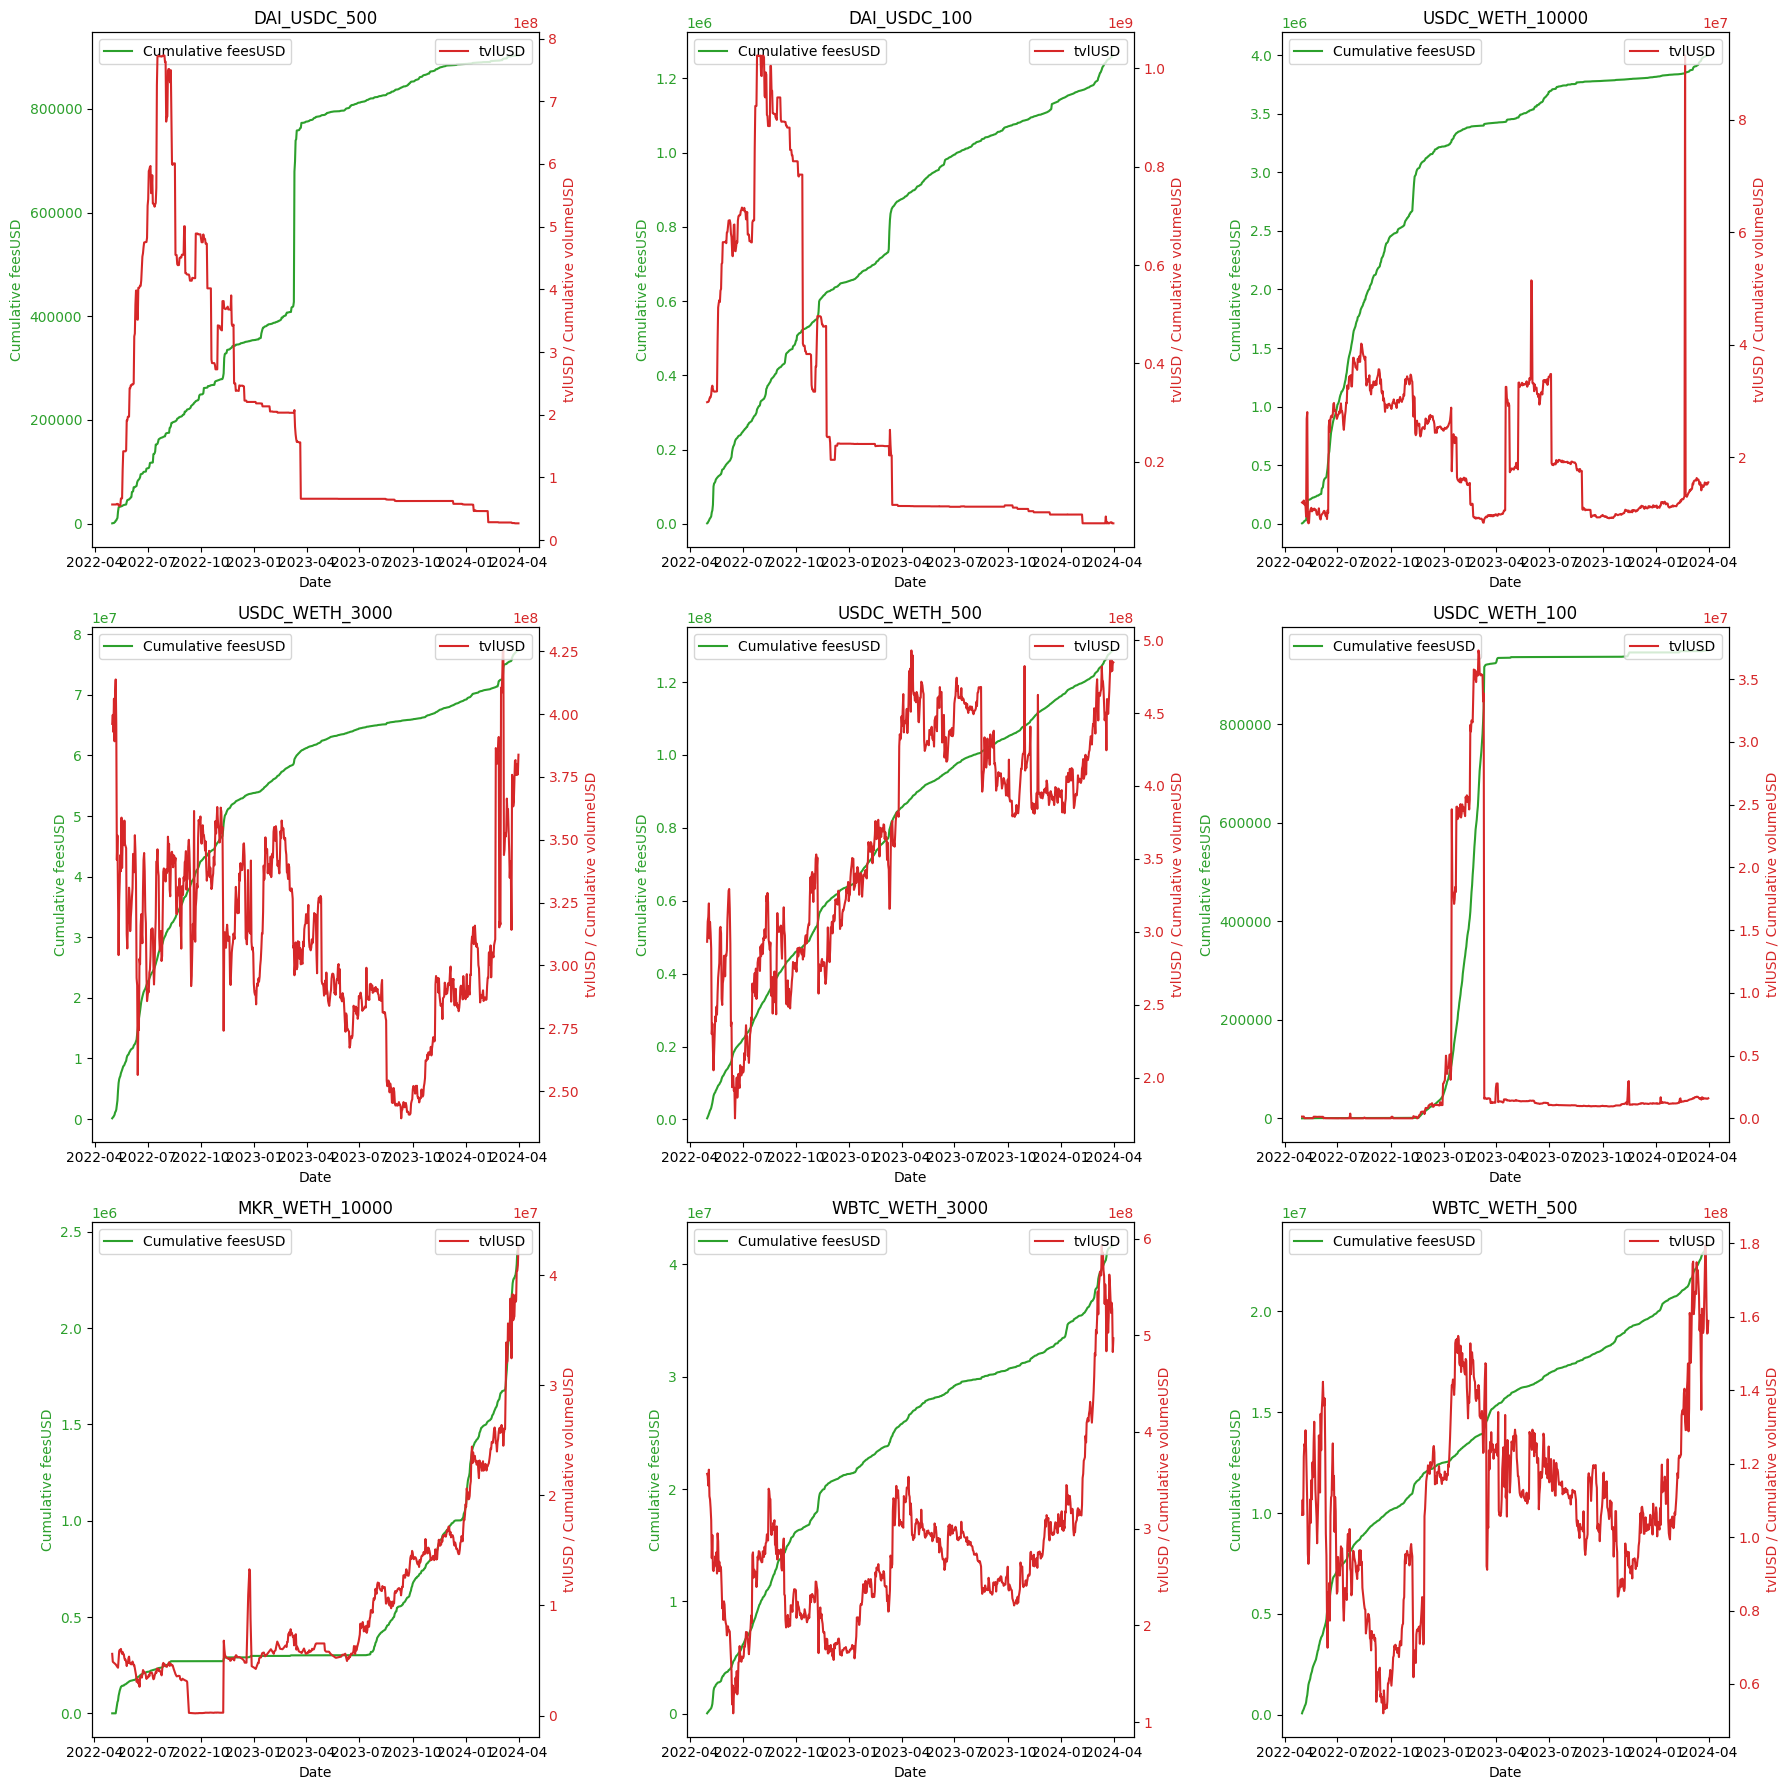

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

axes = axes.flatten()

# Iterate over each key in the pool_data dictionary
for i, (pool_name, data) in enumerate(pool_data.items()):
    # Create DataFrame from the provided data
    pool_df = pd.DataFrame(data)

    # Convert 'date' from days since epoch to datetime
    pool_df['date'] = pd.to_datetime(pool_df['date'], origin='1970-01-01', unit='D')

    # Set datatypes for the columns
    pool_df['tvlUSD'] = pool_df['tvlUSD'].astype(float)
    pool_df['feesUSD'] = pool_df['feesUSD'].astype(float)
    pool_df['volumeUSD'] = pool_df['volumeUSD'].astype(float)

    # Round tvlUSD to 4 decimals
    pool_df['tvlUSD'] = pool_df['tvlUSD'].round(4)

    # Cumulate the feesUSD and volumeUSD over time
    pool_df['cum_feesUSD'] = pool_df['feesUSD'].cumsum()
    pool_df['cum_volumeUSD'] = pool_df['volumeUSD'].cumsum()

    # Describe cum_feesUSD
    print(f"Statistics for {pool_name}:")
    print(pool_df['cum_feesUSD'].describe())

    # Plot the data
    ax1 = axes[i]
    ax1.plot(pool_df['date'], pool_df['cum_feesUSD'], color='tab:green', label='Cumulative feesUSD')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative feesUSD', color='tab:green')
    ax1.tick_params(axis='y', labelcolor='tab:green')
    ax1.legend(loc='upper left')

    # Create a second y-axis for tvlUSD and cumulative volumeUSD
    ax2 = ax1.twinx()
    ax2.plot(pool_df['date'], pool_df['tvlUSD'], color='tab:red', label='tvlUSD')
    #ax2.plot(pool_df['date'], pool_df['cum_volumeUSD'], color='tab:orange', label='Cumulative volumeUSD')
    ax2.set_ylabel('tvlUSD / Cumulative volumeUSD', color='tab:red')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax2.legend(loc='upper right')

    # Title and layout adjustments
    ax1.set_title(f'{pool_name}')

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

Statistics for DAI_USDC_500:
count       700.000000
mean     573150.050299
std      311860.050447
min         589.757000
25%      267478.074050
50%      782668.506400
75%      855907.554700
max      902904.611300
Name: cum_feesUSD, dtype: float64
Statistics for DAI_USDC_100:
count    7.010000e+02
mean     7.868467e+05
std      3.342578e+05
min      1.309735e+03
25%      5.306277e+05
50%      8.924700e+05
75%      1.073332e+06
max      1.261735e+06
Name: cum_feesUSD, dtype: float64
Statistics for USDC_WETH_10000:
count    6.830000e+02
mean     3.015136e+06
std      1.074974e+06
min      3.522302e+03
25%      2.528959e+06
50%      3.428694e+06
75%      3.782718e+06
max      3.998170e+06
Name: cum_feesUSD, dtype: float64
Statistics for USDC_WETH_3000:
count    7.010000e+02
mean     5.402458e+07
std      1.815025e+07
min      1.273015e+05
25%      4.449728e+07
50%      6.176979e+07
75%      6.606108e+07
max      7.732777e+07
Name: cum_feesUSD, dtype: float64
Statistics for USDC_WETH_500:
c

C:\Users\thano\AppData\Local\Temp\ipykernel_71120\3075966264.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  il_df['event_timestamp'] = pd.to_datetime(il_df['event_timestamp'], unit='s')
C:\Users\thano\AppData\Local\Temp\ipykernel_71120\3075966264.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  il_df['event_timestamp'] = pd.to_datetime(il_df['event_timestamp'], unit='s')
C:\Users\thano\AppData\Local\Temp\ipykernel_71120\3075966264.py:56: SettingWithCopyWarning: 
A value is trying to be set on a co

Statistics for WBTC_WETH_3000:
count    7.010000e+02
mean     2.374919e+07
std      1.004491e+07
min      5.437199e+04
25%      1.681364e+07
50%      2.666302e+07
75%      3.077370e+07
max      4.166347e+07
Name: cum_feesUSD, dtype: float64
Statistics for WBTC_WETH_500:
count    7.010000e+02
mean     1.437865e+07
std      5.208817e+06
min      6.586368e+04
25%      1.049025e+07
50%      1.570357e+07
75%      1.824653e+07
max      2.327027e+07
Name: cum_feesUSD, dtype: float64


C:\Users\thano\AppData\Local\Temp\ipykernel_71120\3075966264.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  il_df['event_timestamp'] = pd.to_datetime(il_df['event_timestamp'], unit='s')
C:\Users\thano\AppData\Local\Temp\ipykernel_71120\3075966264.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  il_df['event_timestamp'] = pd.to_datetime(il_df['event_timestamp'], unit='s')
C:\Users\thano\AppData\Local\Temp\ipykernel_71120\3075966264.py:56: SettingWithCopyWarning: 
A value is trying to be set on a co

NameError: name 'num_rows' is not defined

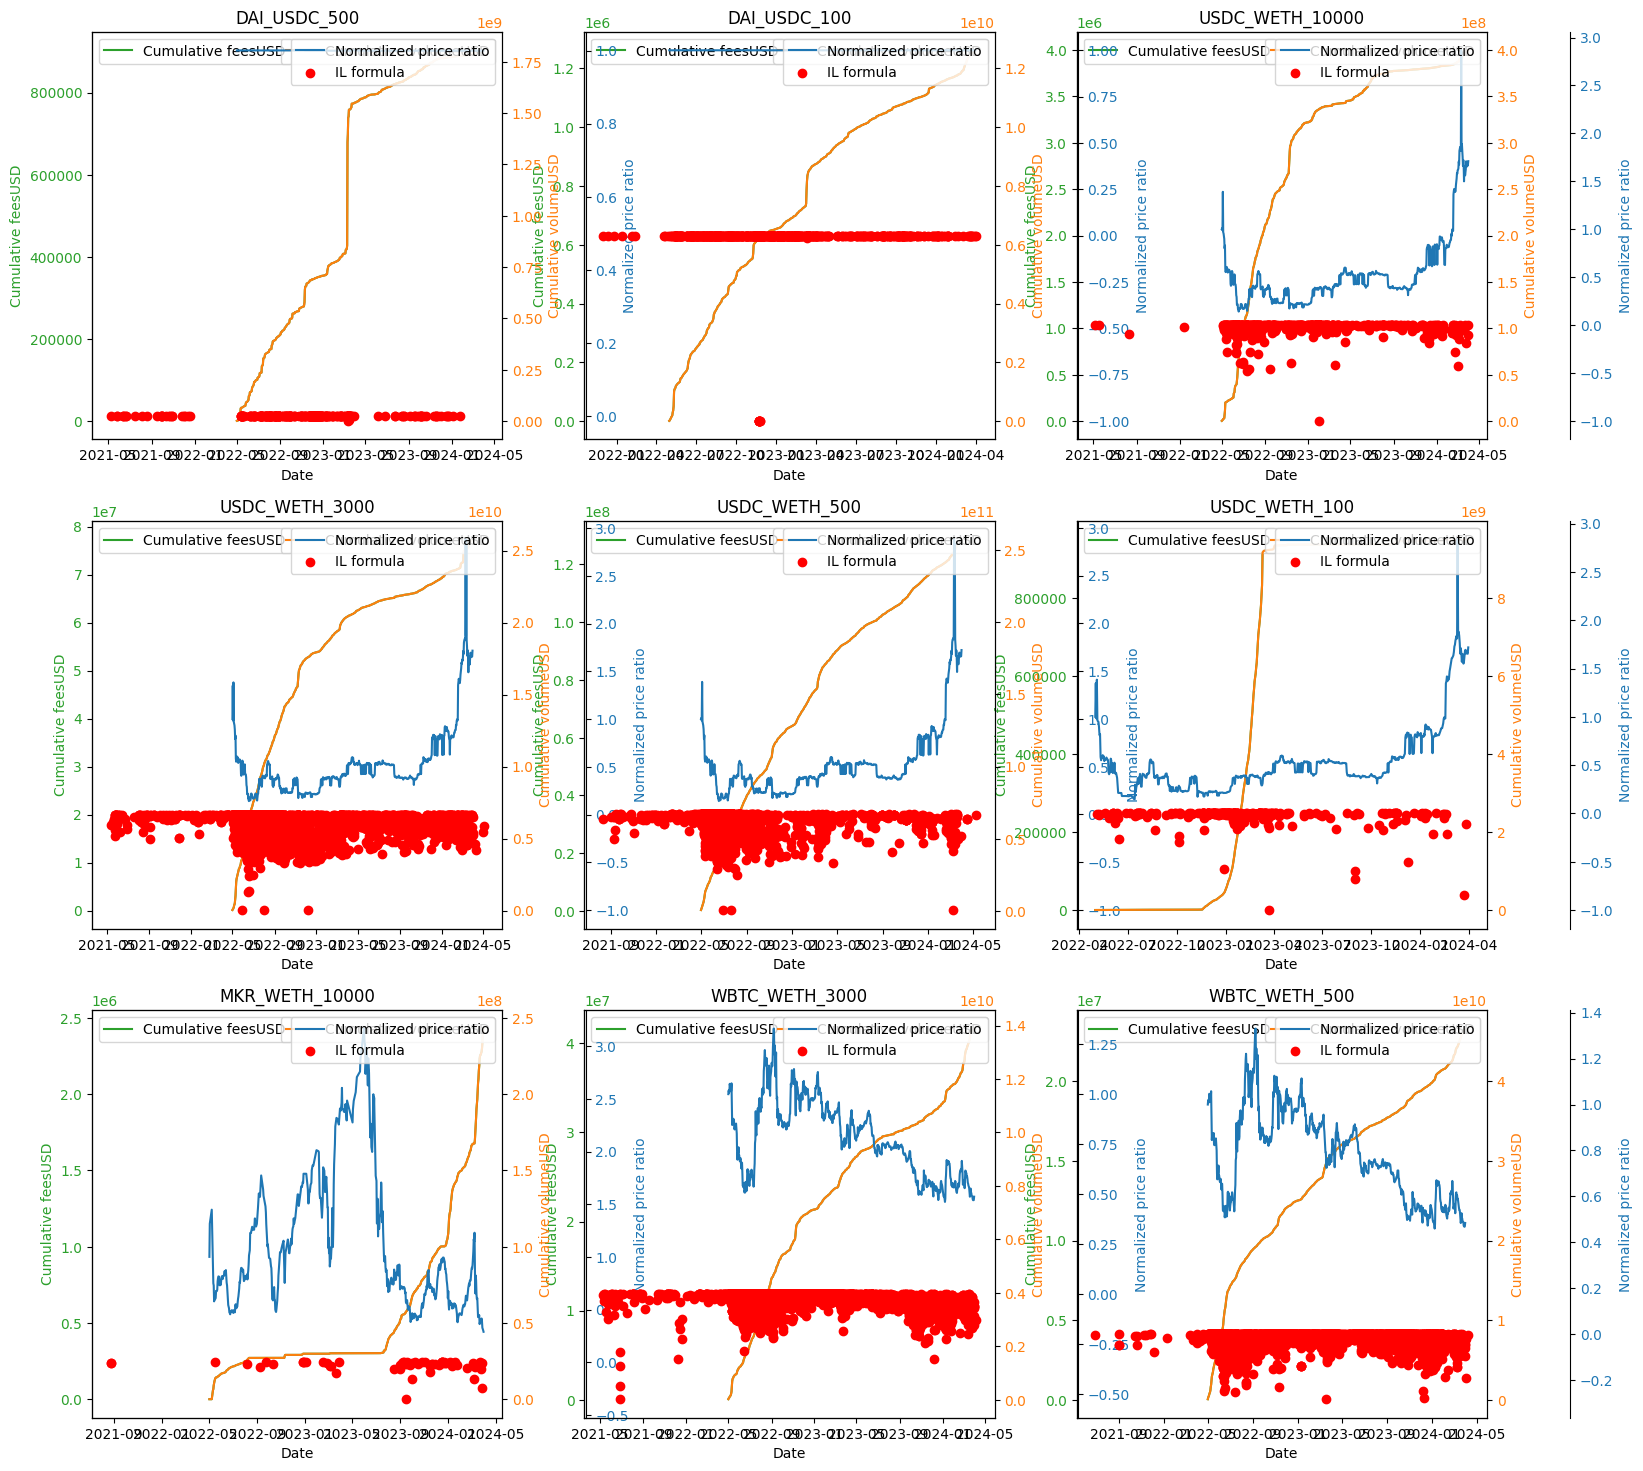

In [35]:
fig, axes = plt.subplots(3, 3, figsize=(18, 18))

axes = axes.flatten()

# Iterate over each key in the pool_data dictionary
for i, (pool_name, data) in enumerate(pool_data.items()):
    # Create DataFrame from the provided data
    pool_df = pd.DataFrame(data)

    # Convert 'date' from days since epoch to datetime, ensure date is integer
    pool_df['date'] = pd.to_datetime(pool_df['date'].astype(int), origin='1970-01-01', unit='D')

    # Set datatypes for the columns
    pool_df['tvlUSD'] = pool_df['tvlUSD'].astype(float)
    pool_df['feesUSD'] = pool_df['feesUSD'].astype(float)
    pool_df['volumeUSD'] = pool_df['volumeUSD'].astype(float)
    pool_df['token0Price'] = pool_df['token0Price'].astype(float)
    pool_df['token1Price'] = pool_df['token1Price'].astype(float)

    # Calculate cumulative sums and normalized price ratio
    pool_df['cum_feesUSD'] = pool_df['feesUSD'].cumsum()
    pool_df['cum_volumeUSD'] = pool_df['volumeUSD'].cumsum()
    pool_df['price_ratio'] = pool_df['token0Price'] / pool_df['token1Price']
    pool_df['normalized_price_ratio'] = pool_df['price_ratio'] / pool_df['price_ratio'].iloc[0]

    # Describe cum_feesUSD
    print(f"Statistics for {pool_name}:")
    print(pool_df['cum_feesUSD'].describe())

    # Plot the data
    ax1 = axes[i]
    ax1.plot(pool_df['date'], pool_df['cum_feesUSD'], color='tab:green', label='Cumulative feesUSD')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative feesUSD', color='tab:green')
    ax1.tick_params(axis='y', labelcolor='tab:green')
    ax1.legend(loc='upper left')

    # Create a second y-axis for cumulative volumeUSD
    ax2 = ax1.twinx()
    ax2.plot(pool_df['date'], pool_df['cum_volumeUSD'], color='tab:orange', label='Cumulative volumeUSD')
    ax2.set_ylabel('Cumulative volumeUSD', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.legend(loc='upper right')

    # Create a third y-axis for normalized price ratio
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("outward", 60))
    ax3.plot(pool_df['date'], pool_df['normalized_price_ratio'], color='tab:blue', label='Normalized price ratio')
    ax3.set_ylabel('Normalized price ratio', color='tab:blue')
    ax3.tick_params(axis='y', labelcolor='tab:blue')
    ax3.legend(loc='lower right')

    # Plot IL_formula as dots
    if pool_name in pool_dataframes:
        il_df = pool_dataframes[pool_name]
        il_df['event_timestamp'] = pd.to_datetime(il_df['event_timestamp'], unit='s')
        ax3.scatter(il_df['event_timestamp'], il_df['IL_formula'], color='red', zorder=5, label='IL formula')
        ax3.legend(loc='upper right')

    # Title and layout adjustments
    ax1.set_title(f'{pool_name}')

# Remove unused subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlap
fig.tight_layout()
plt.show()

In [34]:
pool_dataframes['DAI_USDC_500']['event_timestamp']

0      1628166792
1      1673124779
2      1692449783
3      1657153859
4      1660913963
          ...    
409    1664721311
410    1631704457
411    1655192992
412    1667047079
413    1655586129
Name: event_timestamp, Length: 330, dtype: int32

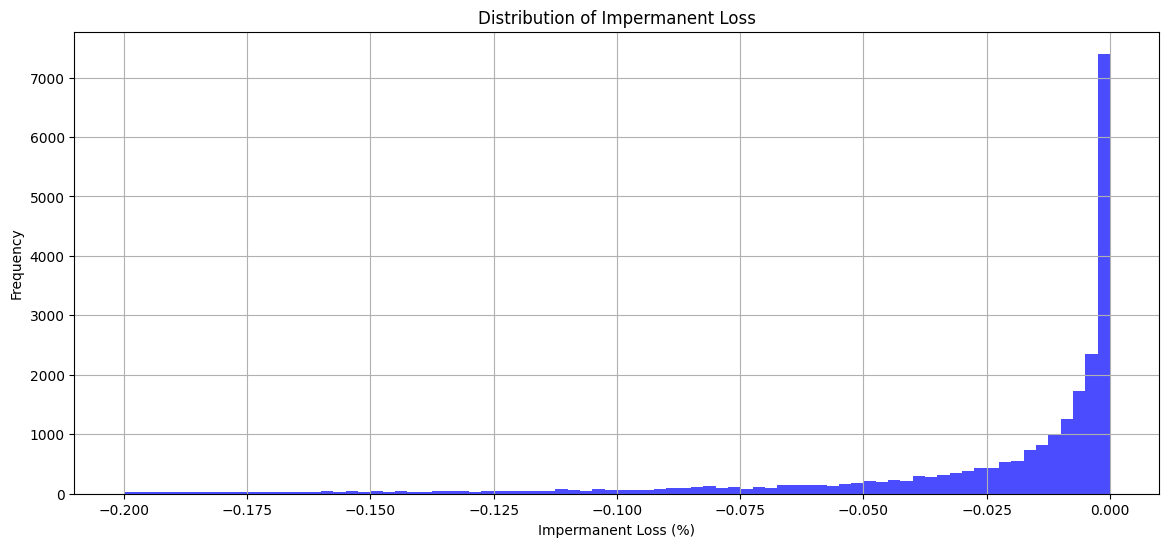

In [ ]:
import matplotlib.pyplot as plt
# Histogram of Impermanent Loss
plt.figure(figsize=(14, 6))
plt.hist(combined_df['IL_final'], bins=80, color='blue', alpha=0.7, range=(-0.2, 0))

plt.title('Distribution of Impermanent Loss')
plt.xlabel('Impermanent Loss (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

C:\Users\thano\AppData\Local\Temp\ipykernel_67656\436225357.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(describe_df.index, rotation=45, ha='right')
C:\Users\thano\AppData\Local\Temp\ipykernel_67656\436225357.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(describe_df.index, rotation=45, ha='right')


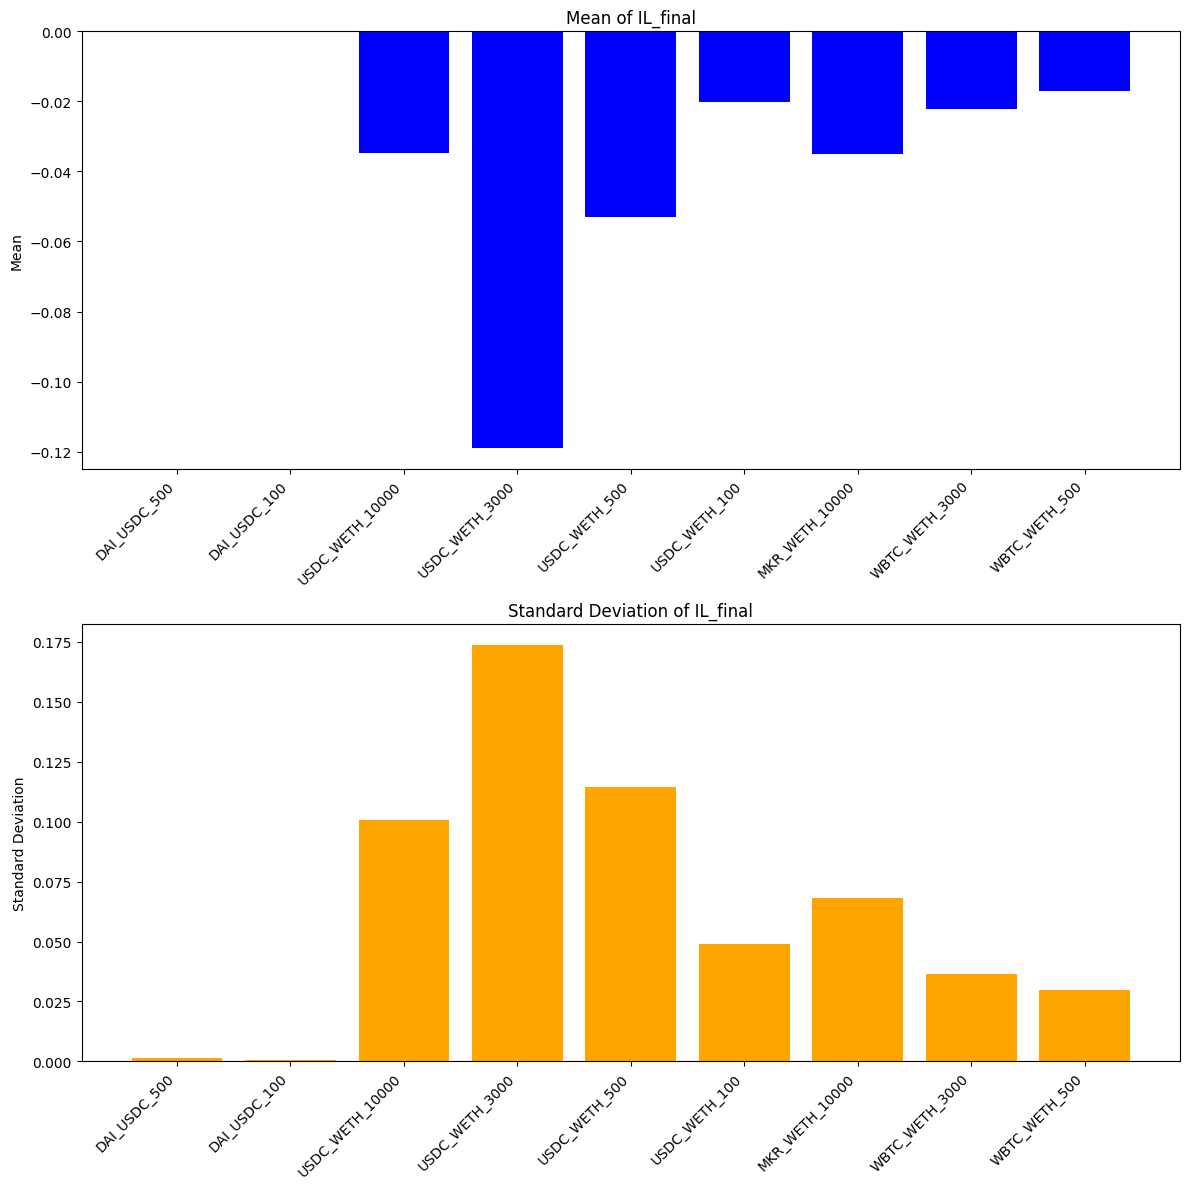

In [ ]:
describe_data = {}

for pool, df in pool_dataframes.items():
    describe_data[pool] = df['IL_final'].describe()

describe_df = pd.DataFrame(describe_data).T

fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot mean
axes[0].bar(describe_df.index, describe_df['mean'], color='blue')
axes[0].set_title('Mean of IL_final')
axes[0].set_ylabel('Mean')
axes[0].set_xticklabels(describe_df.index, rotation=45, ha='right')

# Plot std
axes[1].bar(describe_df.index, describe_df['std'], color='orange')
axes[1].set_title('Standard Deviation of IL_final')
axes[1].set_ylabel('Standard Deviation')
axes[1].set_xticklabels(describe_df.index, rotation=45, ha='right')

plt.tight_layout()
plt.show()

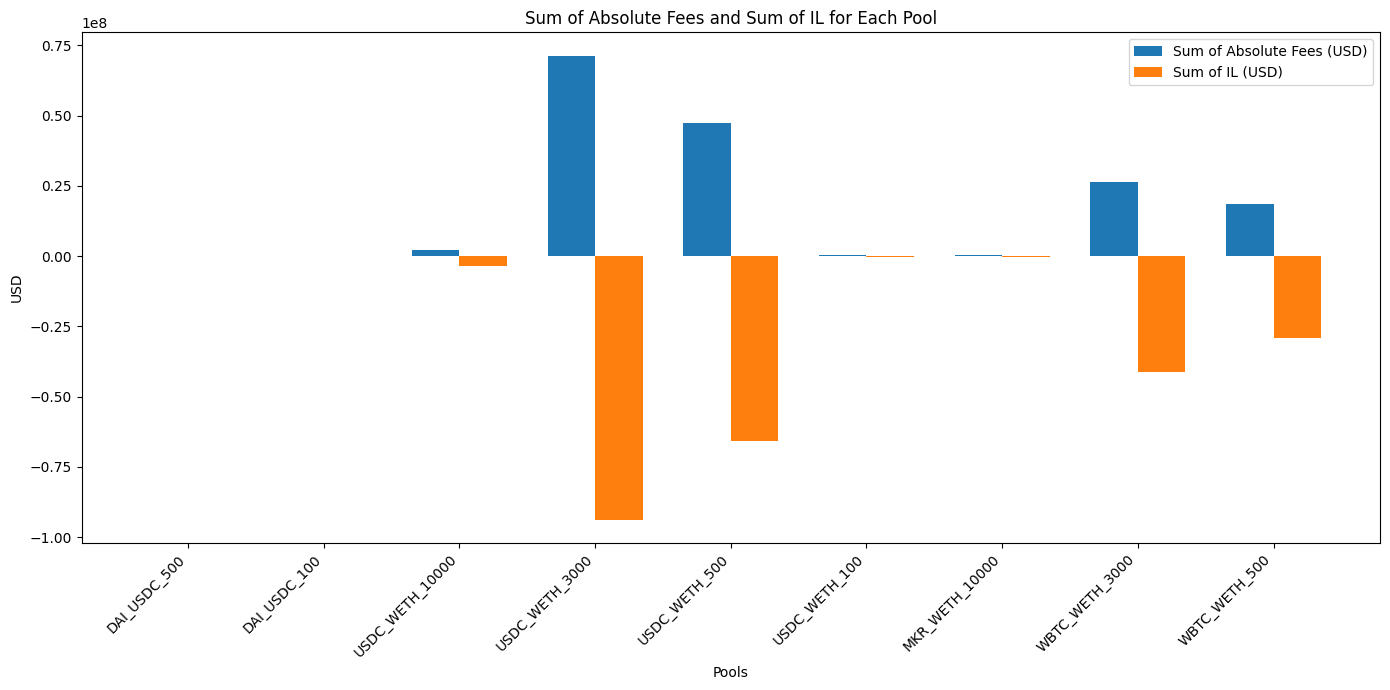

In [27]:
fees_IL_data = {
    'pool': [],
    'sum_feesUSD': [],
    'sum_lossVersusHODLExact': []
}
for pool in pool_dataframes:
    fees_IL_data['pool'].append(pool)
    fees_IL_data['sum_feesUSD'].append(pool_dataframes[pool]['event_feesUSD'].sum())
    fees_IL_data['sum_lossVersusHODLExact'].append(pool_dataframes[pool]['lossVersusHODLExact'].sum())

# Converting to DataFrame for easy plotting
fees_IL_df = pd.DataFrame(fees_IL_data)

# Plotting the combined bar chart
fig, ax = plt.subplots(figsize=(14, 7))

bar_width = 0.35
index = np.arange(len(fees_IL_df['pool']))

bar1 = ax.bar(index, fees_IL_df['sum_feesUSD'], bar_width, label='Sum of Absolute Fees (USD)')
bar2 = ax.bar(index + bar_width, fees_IL_df['sum_lossVersusHODLExact'], bar_width, label='Sum of IL (USD)')

ax.set_xlabel('Pools')
ax.set_ylabel('USD')
ax.set_title('Sum of Absolute Fees and Sum of IL for Each Pool')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(fees_IL_df['pool'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

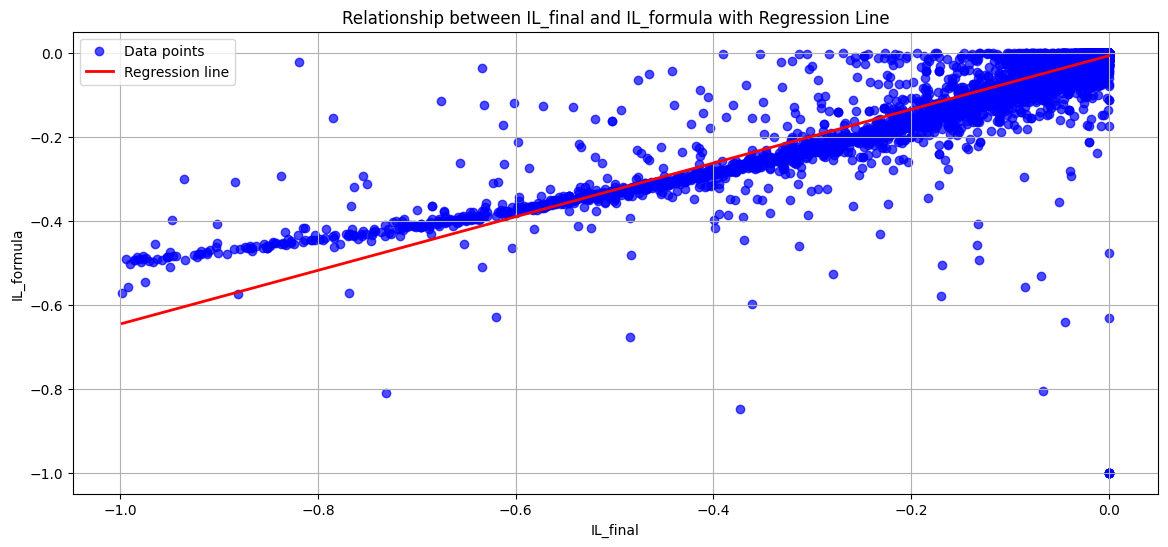

[0.63841606] -0.00766479058480643
R2 0.8495141623145579


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score

# Scatter plot of IL_final vs IL_formula
plt.figure(figsize=(14, 6))
plt.scatter(risky_combined_df['IL_final'], risky_combined_df['IL_formula'], color='blue', alpha=0.7, label='Data points')

# Fit a linear regression model
X = risky_combined_df[['IL_final']].values  # Reshape for sklearn
y = risky_combined_df['IL_formula'].values
model = LinearRegression()
model.fit(X, y)

# Create a range of values for IL_final for plotting the regression line
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_range = model.predict(X_range)

# Plot the regression line
plt.plot(X_range, y_range, color='red', linewidth=2, label='Regression line')

plt.title('Relationship between IL_final and IL_formula with Regression Line')
plt.xlabel('IL_final')
plt.ylabel('IL_formula')
plt.grid(True)
plt.legend()
plt.show()

print(model.coef_, model.intercept_)

# r2 score
print("R2" , r2_score(y, model.predict(X)))


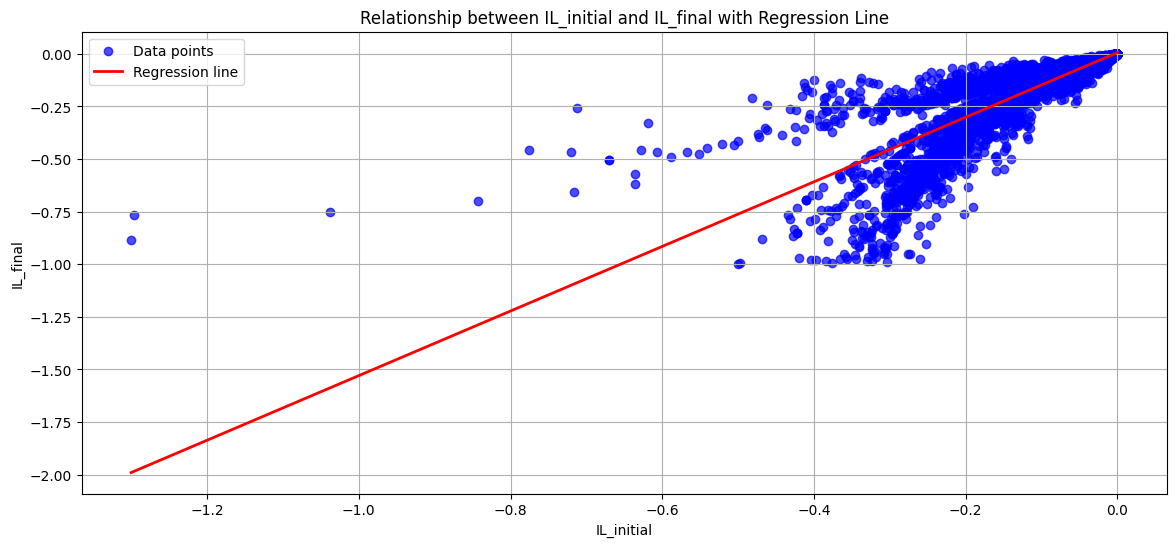

[1.53558183] 0.005868026879378235


0.8004109949721392

Extracted ID:0x6c6bc977e13df9b0de53b251522280bb72383700
Date:  19372 Result:  [    date txCount                        tvlUSD
0  19372      30  213451408.136430429214967863]
Extracted ID:0x6c6bc977e13df9b0de53b251522280bb72383700
Date:  19373 Result:  [    date txCount                        tvlUSD
0  19373      62  213474944.673530147285054374]
Extracted ID:0x6c6bc977e13df9b0de53b251522280bb72383700
Date:  19374 Result:  [    date txCount                               tvlUSD
0  19374      37  213457330.1447184870886076470000001]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import r2_score

# Scatter plot of IL_initial vs IL_final
plt.figure(figsize=(14, 6))
plt.scatter(risky_combined_df['IL_initial'], risky_combined_df['IL_final'], color='blue', alpha=0.7, label='Data points')

# Fit a linear regression model
X = risky_combined_df[['IL_initial']].values  # Reshape for sklearn
y = risky_combined_df['IL_final'].values
model = LinearRegression()
model.fit(X, y)

# Create a range of values for IL_initial for plotting the regression line
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_range = model.predict(X_range)

# Plot the regression line
plt.plot(X_range, y_range, color='red', linewidth=2, label='Regression line')

plt.title('Relationship between IL_initial and IL_final with Regression Line')
plt.xlabel('IL_initial')
plt.ylabel('IL_final')
plt.grid(True)
plt.legend()
plt.show()

print(model.coef_, model.intercept_)

# r2 score
r2_score(y, model.predict(X))

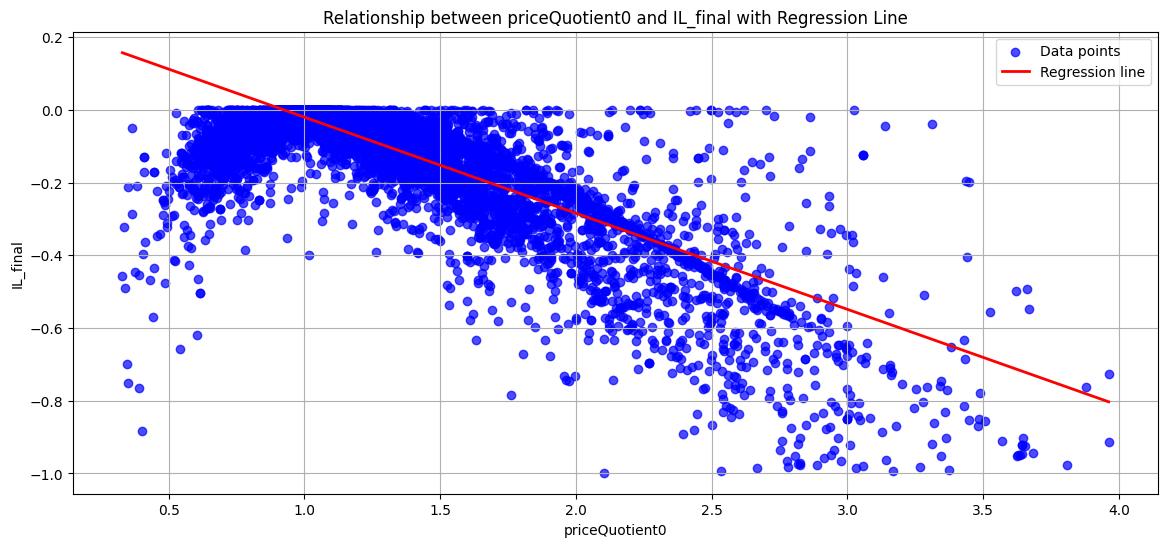

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Scatter plot of priceQuotient0 vs IL_final
plt.figure(figsize=(14, 6))
plt.scatter(combined_df['priceQuotient0'], combined_df['IL_final'], color='blue', alpha=0.7, label='Data points')

# Fit a linear regression model
X = combined_df[['priceQuotient0']].values  # Reshape for sklearn
y = combined_df['IL_final'].values
model = LinearRegression()
model.fit(X, y)

# Create a range of values for priceQuotient0 for plotting the regression line
X_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_range = model.predict(X_range)

# Plot the regression line
plt.plot(X_range, y_range, color='red', linewidth=2, label='Regression line')

plt.title('Relationship between priceQuotient0 and IL_final with Regression Line')
plt.xlabel('priceQuotient0')
plt.ylabel('IL_final')
plt.grid(True)
plt.legend()
plt.show()


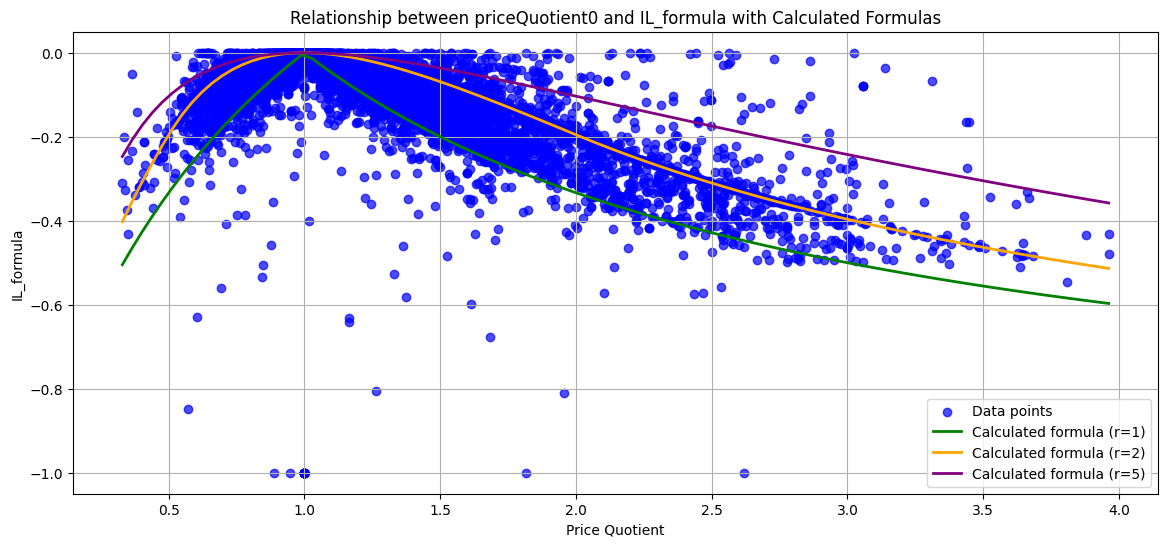

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming combined_df is already defined and filtered

# Scatter plot of priceQuotient0 vs IL_formula
plt.figure(figsize=(14, 6))
plt.scatter(combined_df['priceQuotient0'], combined_df['IL_formula'], color='blue', alpha=0.7, label='Data points')

# Calculate the formula values using the provided piecewise formula for different r values
def calculate_formula(r, d):
    if d < 1/r:
        return (np.sqrt(r) * d - 1) / (1 + d)
    elif 1/r <= d <= r:
        return (np.sqrt(r) / (np.sqrt(r) - 1)) * (2 * np.sqrt(d) / (1 + d) - 1)
    else:  # d > r
        return (np.sqrt(r) - d) / (1 + d)

# Plot the calculated formula for different r values
r_values = [1, 2, 5]
colors = ['green', 'orange', 'purple']

# Create a range of values for priceQuotient0 for plotting the formula
d_range = np.linspace(combined_df['priceQuotient0'].min(), combined_df['priceQuotient0'].max(), 100)

for r, color in zip(r_values, colors):
    calculated_formula_values = [calculate_formula(r, d) for d in d_range]
    plt.plot(d_range, calculated_formula_values, color=color, linewidth=2, label=f'Calculated formula (r={r})')

plt.title('Relationship between priceQuotient0 and IL_formula with Calculated Formulas')
plt.xlabel('Price Quotient')
plt.ylabel('IL_formula')
plt.grid(True)
plt.legend()
plt.show()


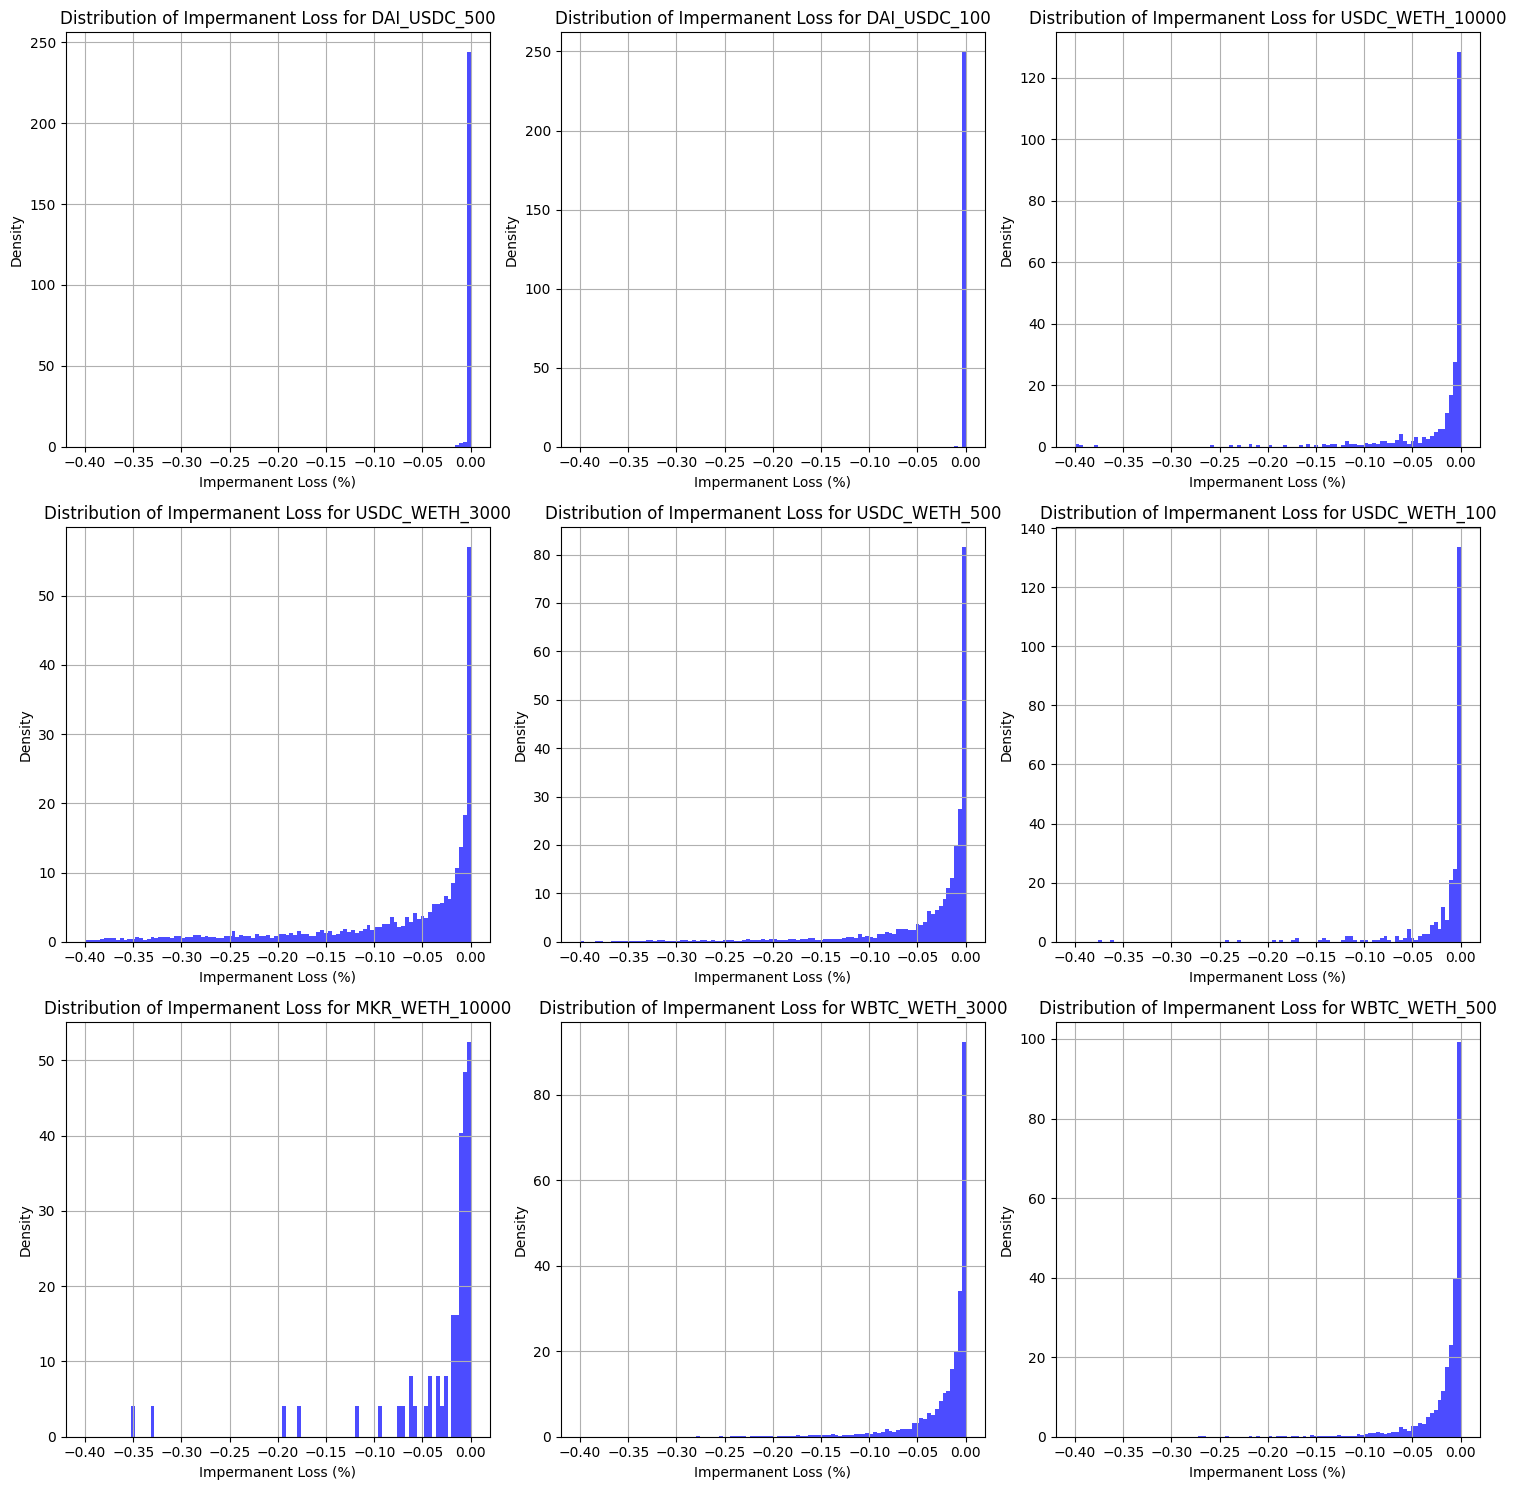

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 3x3 array of axes to simplify indexing

# Iterate through each DataFrame and its corresponding axis
for ax, (key, df) in zip(axes, pool_dataframes.items()):
    # Plot the histogram directly on the designated axis
    ax.hist(df['IL_final'], bins=100, color='blue', alpha=0.7, range=(-0.4, 0), density=True)
    ax.set_title('Distribution of Impermanent Loss for ' + key)
    ax.set_xlabel('Impermanent Loss (%)')
    ax.set_ylabel('Density')
    ax.grid(True)

# If there are any unused subplots, turn them off
for i in range(len(pool_dataframes), 9):
    axes[i].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


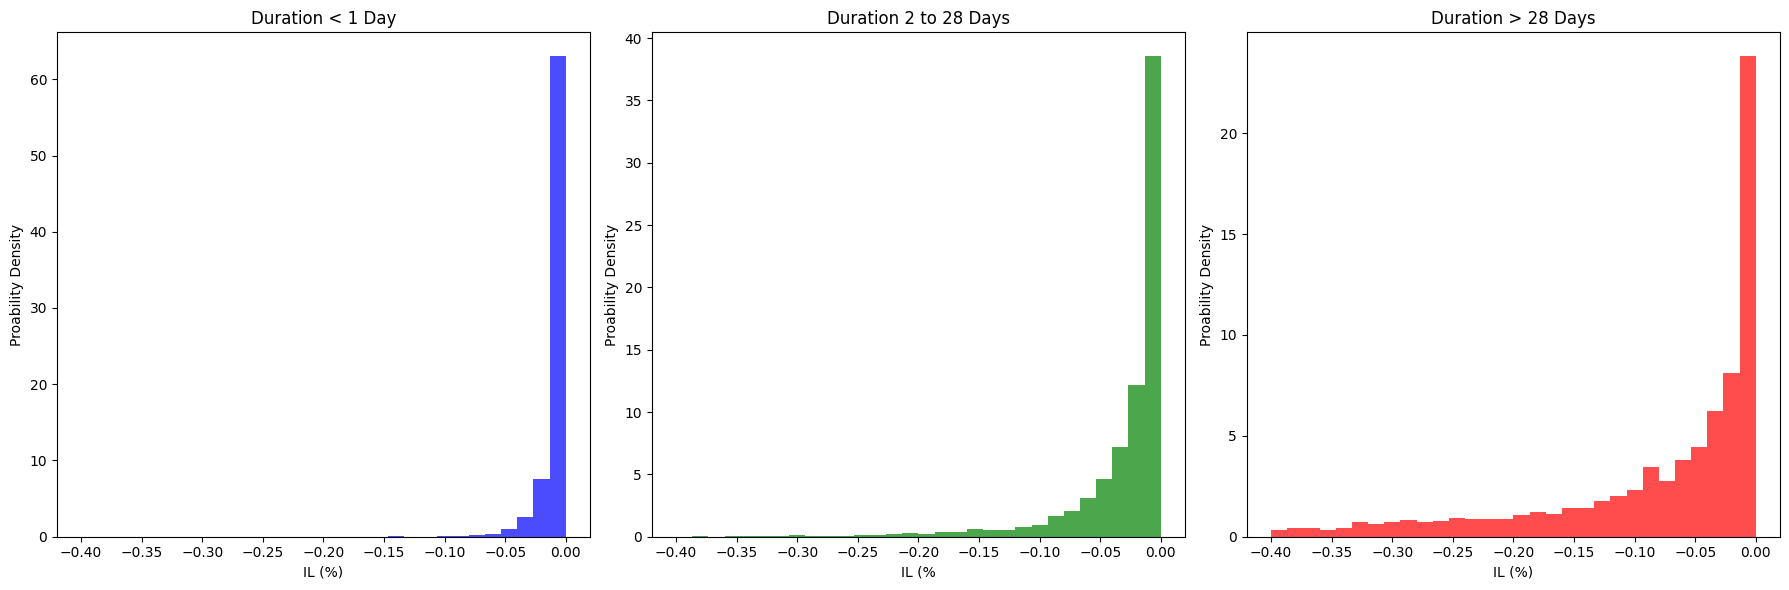

In [ ]:
risky_combined_df['weightedDurationDays'] = risky_combined_df['weightedDurationSeconds'] / (3600 * 24)

less_than_1_day = risky_combined_df[risky_combined_df['weightedDurationDays'] < 1]
between_2_and_28_days = risky_combined_df[(risky_combined_df['weightedDurationDays'] >= 2) & (risky_combined_df['weightedDurationDays'] <= 28)]
more_than_28_days = risky_combined_df[risky_combined_df['weightedDurationDays'] > 28]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axes[0].hist(less_than_1_day['IL_final'], bins=30, color='blue', alpha=0.7, density=True, range=(-0.4, 0))
axes[0].set_title('Duration < 1 Day')
axes[0].set_xlabel('IL (%)')
axes[0].set_ylabel('Proability Density')

axes[1].hist(between_2_and_28_days['IL_final'], bins=30, color='green', alpha=0.7, density=True, range=(-0.4, 0))
axes[1].set_title('Duration 2 to 28 Days')
axes[1].set_xlabel('IL')
axes[1].set_ylabel('Proability Density')

axes[2].hist(more_than_28_days['IL_final'], bins=30, color='red', alpha=0.7, density=True, range=(-0.4, 0))
axes[2].set_title('Duration > 28 Days')
axes[2].set_xlabel('IL')
axes[2].set_ylabel('Proability Density')

plt.tight_layout()
plt.show()


Range size for DAI_USDC_500:
     price0_upper  price0_lower
0        1.001404      0.999403
1        1.001404      0.999403
2        1.001404      0.999403
3        1.002405      0.998404
4        1.001404      1.000403
..            ...           ...
409      1.001404      0.999403
410      1.010456      0.990449
411      1.002405      1.000403
412      1.004412      0.995413
413      1.002405      0.999403

[330 rows x 2 columns]
Range size for DAI_USDC_100:
     price0_upper  price0_lower
0        1.000203      1.000003
2        1.000203      0.999703
4        1.000203      0.999703
5        1.000203      0.999703
6        1.000203      0.999703
..            ...           ...
807      1.000003      0.999903
808      1.000203      0.999803
809      1.000003      0.999903
814      1.000003      0.999903
815      1.009447      0.989459

[686 rows x 2 columns]
Range size for USDC_WETH_10000:
     price0_upper  price0_lower
0        0.000168      0.000077
1        0.000629      0.00015

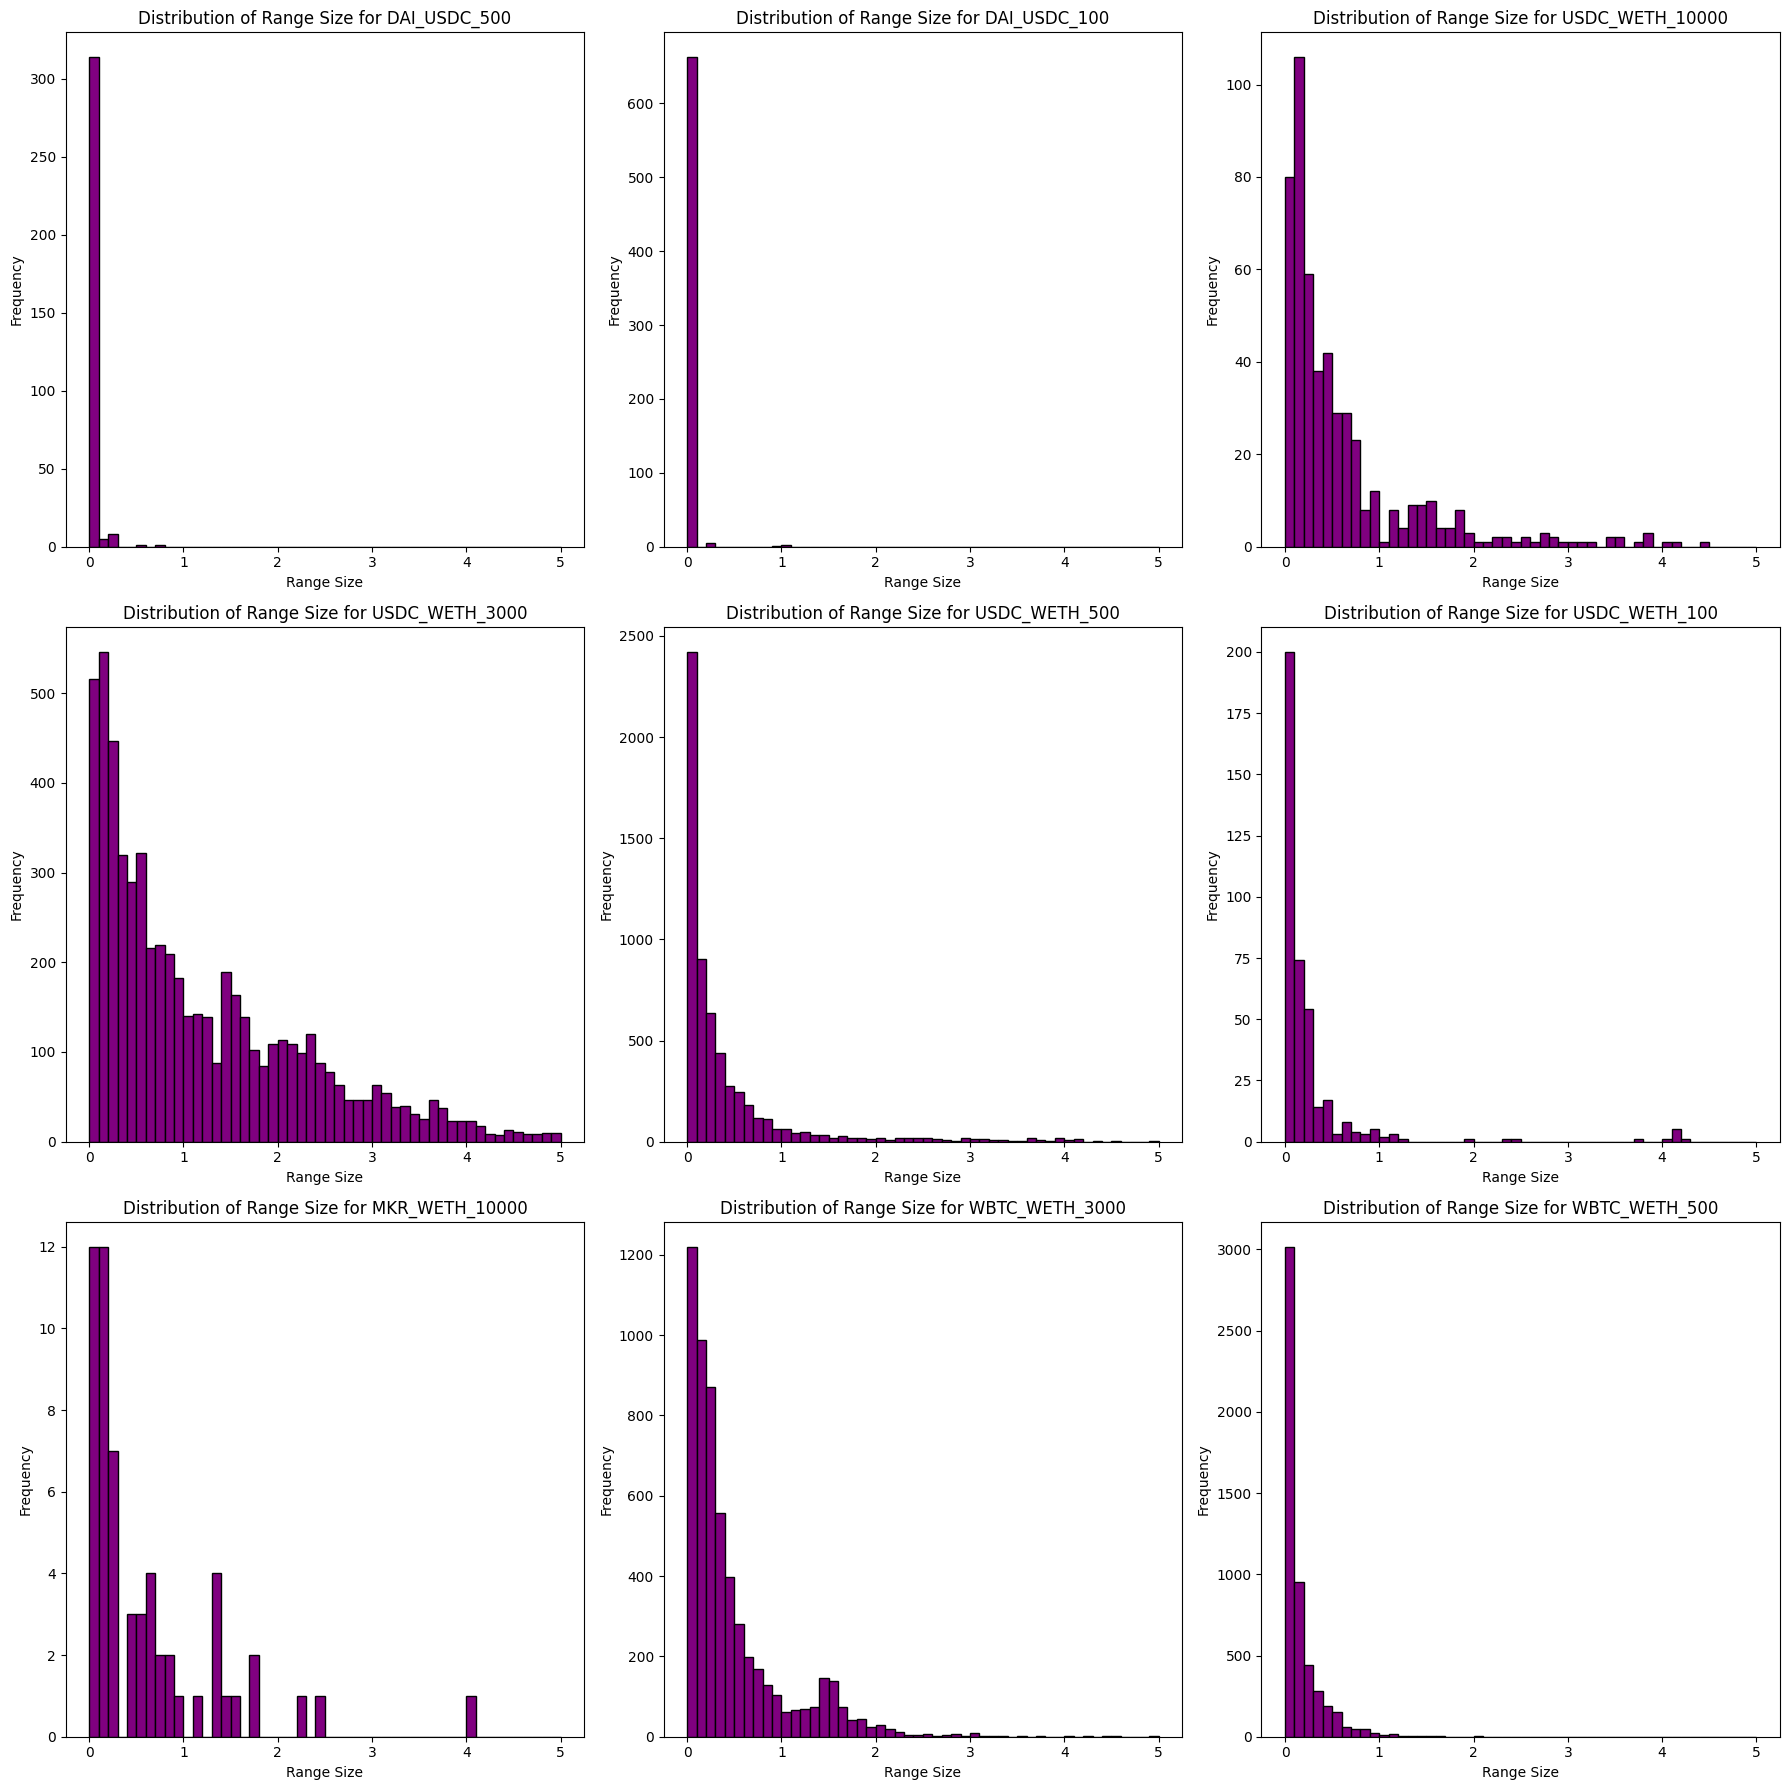

In [ ]:
range_size_data = {}

for pool in pool_dataframes:
    pool_dataframes[pool].loc[:, 'range_size'] = (pool_dataframes[pool]['price1_upper'] - pool_dataframes[pool]['price1_lower']) / (pool_dataframes[pool]['price_1'] / pool_dataframes[pool]['price_0'])
    print(f"Range size for {pool}:")
    print(pool_dataframes[pool][['price0_upper', 'price0_lower']])
    range_size_data[pool] = pool_dataframes[pool]['range_size']

# Plotting the distribution of range_size for each pool
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
axes = axes.flatten()

for idx, (pool, range_size) in enumerate(range_size_data.items()):
    axes[idx].hist(range_size, bins=50, color='purple', edgecolor='black', range = (0, 5))
    axes[idx].set_title(f'Distribution of Range Size for {pool}')
    axes[idx].set_xlabel('Range Size')
    axes[idx].set_ylabel('Frequency')
    print(range_size.describe())

plt.tight_layout()
plt.show()


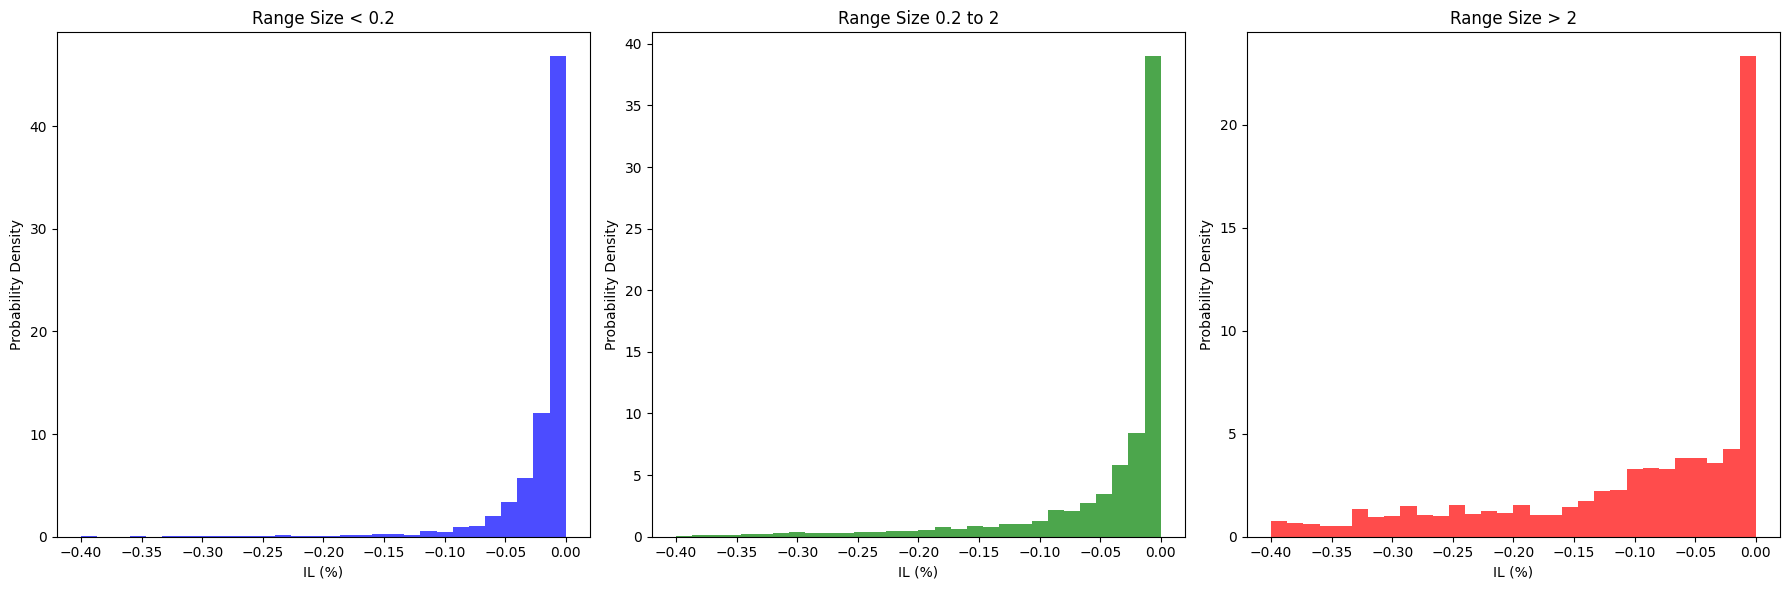

In [ ]:
# Calculate range_size
risky_combined_df['range_size'] = (risky_combined_df['price1_upper'] - risky_combined_df['price1_lower']) / (risky_combined_df['price_1'] / risky_combined_df['price_0'])

# Defining the buckets
less_than_0_2 = risky_combined_df[risky_combined_df['range_size'] < 0.2]
between_0_2_and_2 = risky_combined_df[(risky_combined_df['range_size'] >= 0.2) & (risky_combined_df['range_size'] <= 2)]
more_than_2 = risky_combined_df[risky_combined_df['range_size'] > 2]

# Plotting the distribution of IL_final for each range_size bucket
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

axes[0].hist(less_than_0_2['IL_final'], bins=30, color='blue', alpha=0.7, density=True, range=(-0.4, 0))
axes[0].set_title('Range Size < 0.2')
axes[0].set_xlabel('IL (%)')
axes[0].set_ylabel('Probability Density')

axes[1].hist(between_0_2_and_2['IL_final'], bins=30, color='green', alpha=0.7, density=True, range=(-0.4, 0))
axes[1].set_title('Range Size 0.2 to 2')
axes[1].set_xlabel('IL (%)')
axes[1].set_ylabel('Probability Density')

axes[2].hist(more_than_2['IL_final'], bins=30, color='red', alpha=0.7, density=True, range=(-0.4, 0))
axes[2].set_title('Range Size > 2')
axes[2].set_xlabel('IL (%)')
axes[2].set_ylabel('Probability Density')

plt.tight_layout()
plt.show()

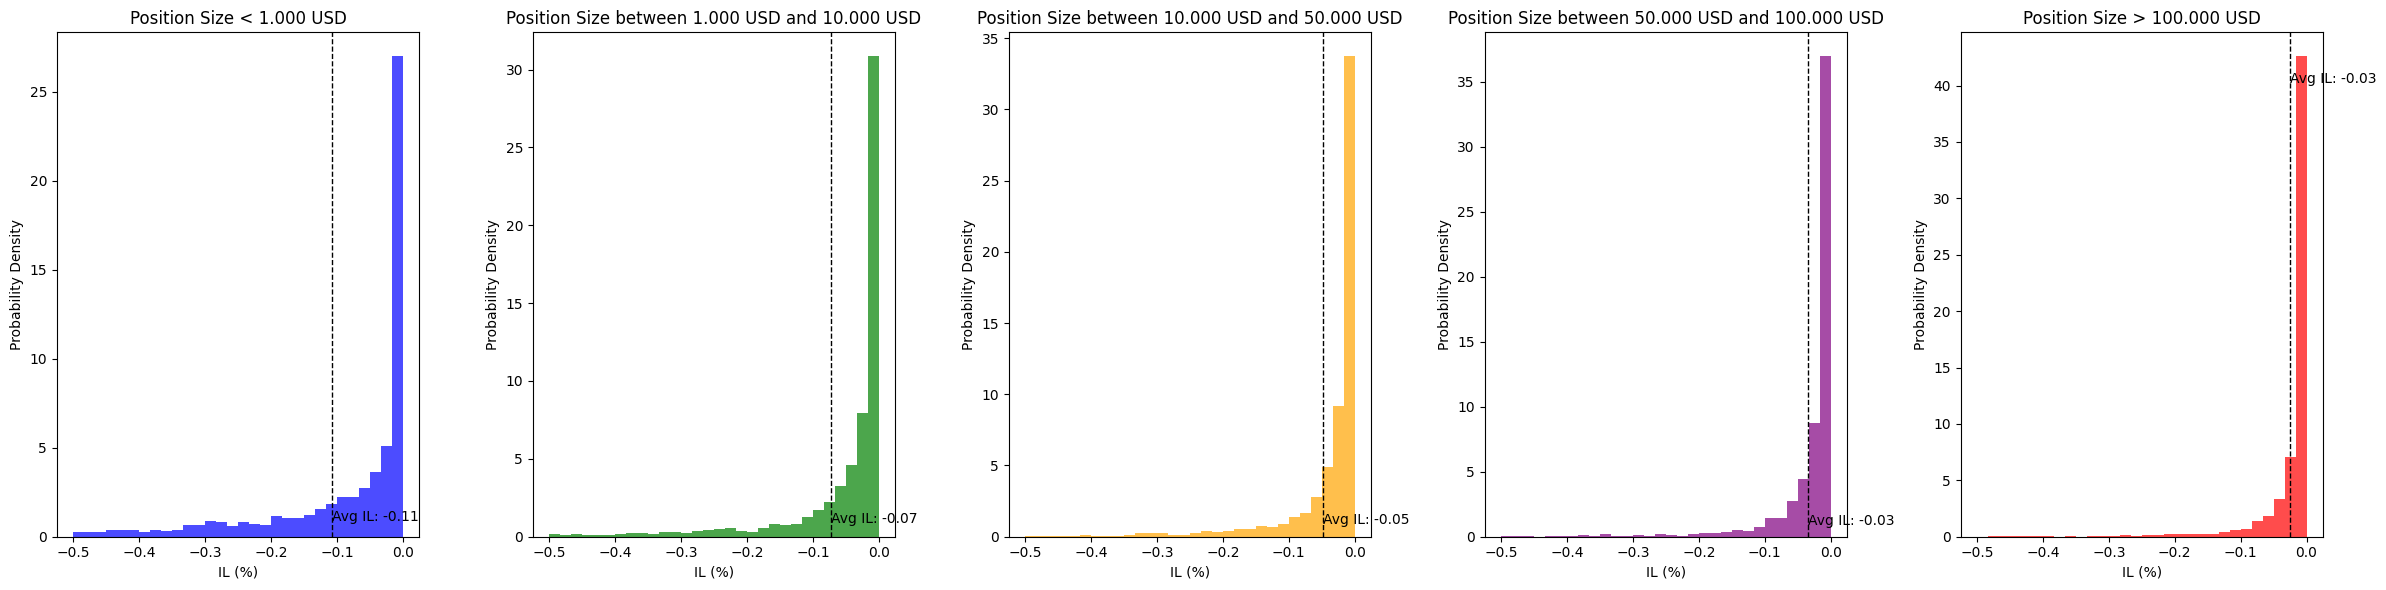

In [ ]:
import matplotlib.pyplot as plt

# Define the data subsets
less_than_1k = risky_combined_df[risky_combined_df['event_amountUSD'] < 1000]
between_1k_and_10k = risky_combined_df[(risky_combined_df['event_amountUSD'] >= 1000) & (risky_combined_df['event_amountUSD'] < 10000)]
between_10k_and_50k = risky_combined_df[(risky_combined_df['event_amountUSD'] >= 10000) & (risky_combined_df['event_amountUSD'] < 50000)]
between_50k_and_100k = risky_combined_df[(risky_combined_df['event_amountUSD'] >= 50000) & (risky_combined_df['event_amountUSD'] <= 100000)]
more_than_100k = risky_combined_df[risky_combined_df['event_amountUSD'] > 100000]

# Calculate the average IL for each group
avg_il_less_than_1k = less_than_1k['IL_final'].mean()
avg_il_between_1k_and_10k = between_1k_and_10k['IL_final'].mean()
avg_il_between_10k_and_50k = between_10k_and_50k['IL_final'].mean()
avg_il_between_50k_and_100k = between_50k_and_100k['IL_final'].mean()
avg_il_more_than_100k = more_than_100k['IL_final'].mean()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(24, 6))

# Plot histogram for less_than_1k
axes[0].hist(less_than_1k['IL_final'], bins=30, color='blue', alpha=0.7, density=True, range=(-0.5, 0))
axes[0].set_title('Position Size < 1.000 USD')
axes[0].set_xlabel('IL (%)')
axes[0].set_ylabel('Probability Density')
axes[0].axvline(avg_il_less_than_1k, color='black', linestyle='dashed', linewidth=1)
axes[0].text(avg_il_less_than_1k, plt.ylim()[1]*0.9, f'Avg IL: {avg_il_less_than_1k:.2f}', color='black')

# Plot histogram for between_1k_and_10k
axes[1].hist(between_1k_and_10k['IL_final'], bins=30, color='green', alpha=0.7, density=True, range=(-0.5, 0))
axes[1].set_title('Position Size between 1.000 USD and 10.000 USD')
axes[1].set_xlabel('IL (%)')
axes[1].set_ylabel('Probability Density')
axes[1].axvline(avg_il_between_1k_and_10k, color='black', linestyle='dashed', linewidth=1)
axes[1].text(avg_il_between_1k_and_10k, plt.ylim()[1]*0.9, f'Avg IL: {avg_il_between_1k_and_10k:.2f}', color='black')

# Plot histogram for between_10k_and_50k
axes[2].hist(between_10k_and_50k['IL_final'], bins=30, color='orange', alpha=0.7, density=True, range=(-0.5, 0))
axes[2].set_title('Position Size between 10.000 USD and 50.000 USD')
axes[2].set_xlabel('IL (%)')
axes[2].set_ylabel('Probability Density')
axes[2].axvline(avg_il_between_10k_and_50k, color='black', linestyle='dashed', linewidth=1)
axes[2].text(avg_il_between_10k_and_50k, plt.ylim()[1]*0.9, f'Avg IL: {avg_il_between_10k_and_50k:.2f}', color='black')

# Plot histogram for between_50k_and_100k
axes[3].hist(between_50k_and_100k['IL_final'], bins=30, color='purple', alpha=0.7, density=True, range=(-0.5, 0))
axes[3].set_title('Position Size between 50.000 USD and 100.000 USD')
axes[3].set_xlabel('IL (%)')
axes[3].set_ylabel('Probability Density')
axes[3].axvline(avg_il_between_50k_and_100k, color='black', linestyle='dashed', linewidth=1)
axes[3].text(avg_il_between_50k_and_100k, plt.ylim()[1]*0.9, f'Avg IL: {avg_il_between_50k_and_100k:.2f}', color='black')

# Plot histogram for more_than_100k
axes[4].hist(more_than_100k['IL_final'], bins=30, color='red', alpha=0.7, density=True, range=(-0.5, 0))
axes[4].set_title('Position Size > 100.000 USD')
axes[4].set_xlabel('IL (%)')
axes[4].set_ylabel('Probability Density')
axes[4].axvline(avg_il_more_than_100k, color='black', linestyle='dashed', linewidth=1)
axes[4].text(avg_il_more_than_100k, plt.ylim()[1]*0.9, f'Avg IL: {avg_il_more_than_100k:.2f}', color='black')

plt.tight_layout()
plt.show()

#TODO: Repositioning intensity

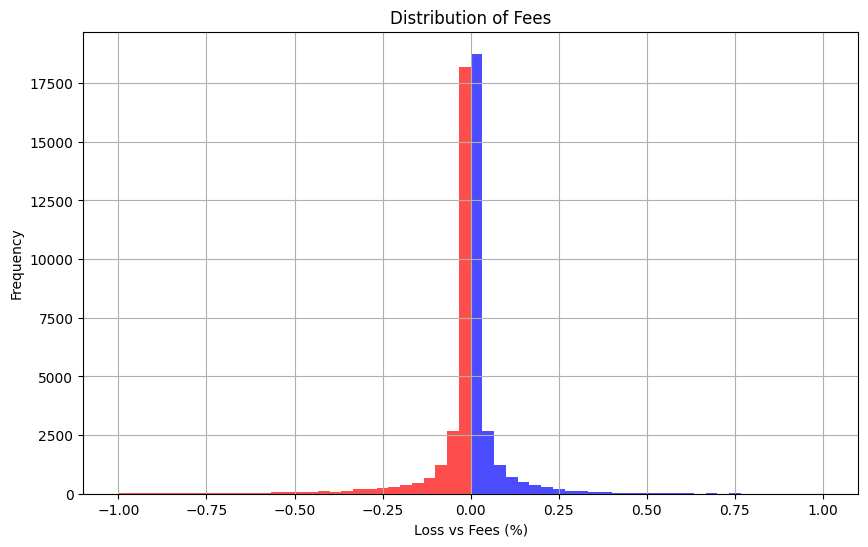

In [ ]:
plt.figure(figsize=(10, 6))
combined_df['relativeFees'] = combined_df['event_feesUSD'] / combined_df['event_amountUSD']
plt.hist(combined_df['relativeFees'], bins=30, color='blue', alpha=0.7, range=(0, 1))
plt.hist(combined_df['IL_final'], bins=30, color='red', alpha=0.7, range=(-1, 0))

plt.title('Distribution of Fees')
plt.xlabel('Loss vs Fees (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

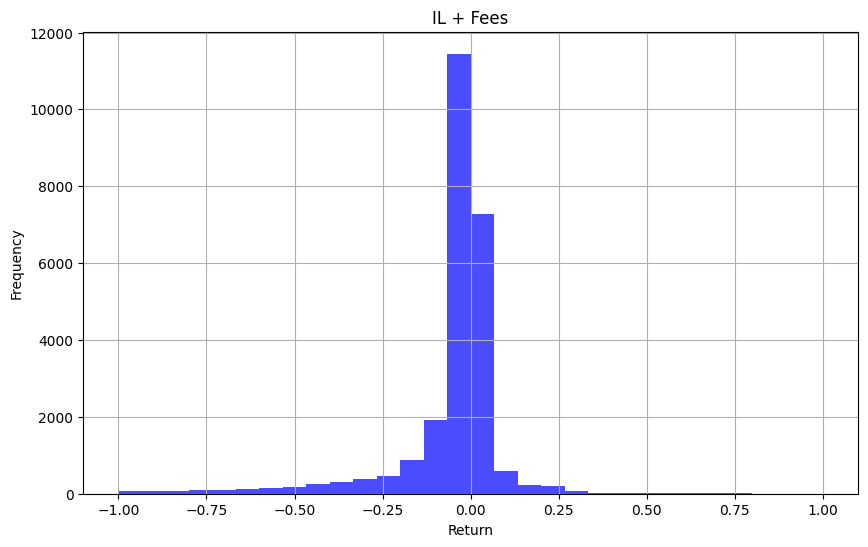

count    25306.000000
mean        -0.056139
std          0.311217
min         -1.933663
25%         -0.048588
50%         -0.006812
75%          0.000681
max         14.494489
Name: percentage_return, dtype: float64

In [ ]:
plt.figure(figsize=(10, 6))
combined_df['percentage_return'] = combined_df['IL_fees'] + combined_df['IL_final']
plt.hist(combined_df['percentage_return'], bins=30, color='blue', alpha=0.7, range=(-1, 1))

plt.title('IL + Fees')
plt.xlabel('Return')
plt.ylabel('Frequency') #umbenennen
plt.grid(True)
plt.show()

combined_df['percentage_return'].describe()

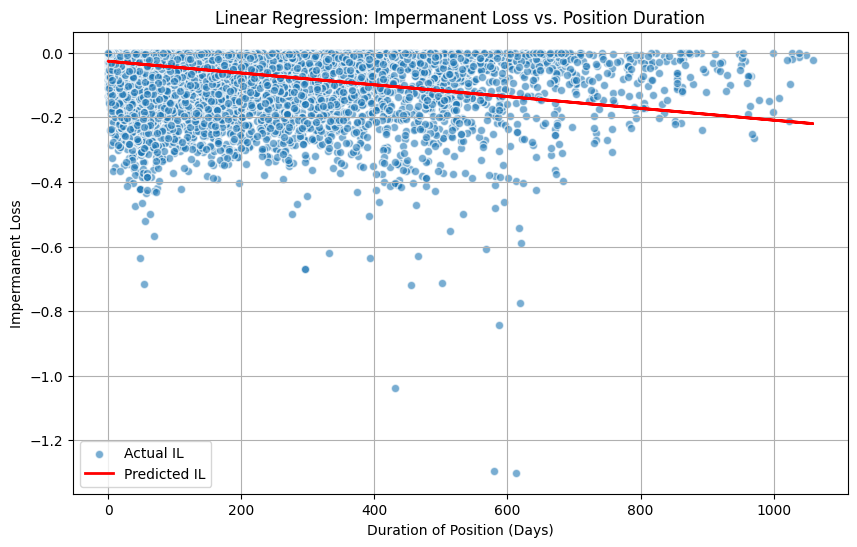

Slope (Coefficient): -0.00018238433920309463
Intercept: -0.026372409893195184
R-squared value: 0.1448


In [ ]:
from sklearn.linear_model import LinearRegression

X = risky_combined_df[['weightedDurationDays']]  # features need to be 2D
y = risky_combined_df['IL_initial'] 

model = LinearRegression()
model.fit(X, y)
risky_combined_df['predicted_IL'] = model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.6, edgecolors='w', label='Actual IL')
plt.plot(X, risky_combined_df['predicted_IL'], color='red', linewidth=2, label='Predicted IL')
plt.title('Linear Regression: Impermanent Loss vs. Position Duration')
plt.xlabel('Duration of Position (Days)')
plt.ylabel('Impermanent Loss')
plt.legend()
plt.grid(True)
plt.show()

print("Slope (Coefficient):", model.coef_[0])
print("Intercept:", model.intercept_)

r_squared = model.score(X, y)
print(f'R-squared value: {r_squared:.4f}')

Mean Squared Error: 0.01318219045526174
R^2 Score: 0.0034103244003981237
Intercept: -0.05476228290232825
Coefficient: 3.922300884289485e-09


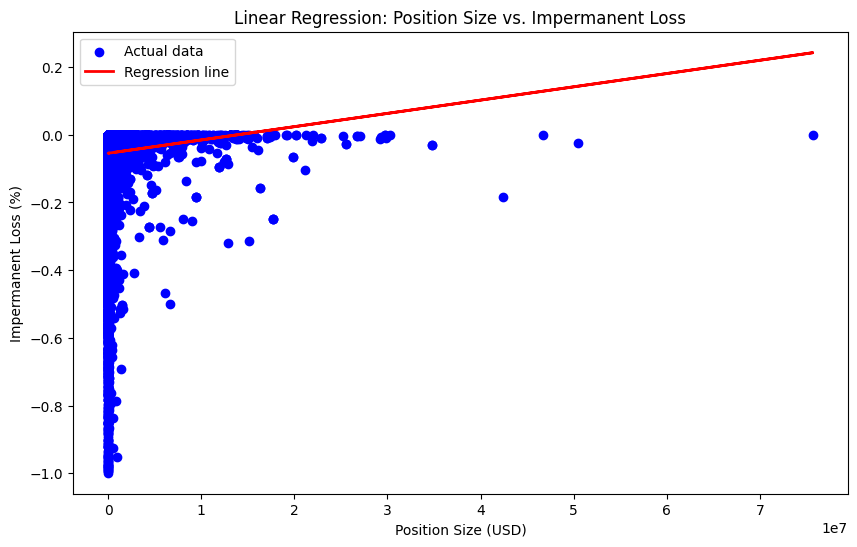

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming risky_combined_df is your DataFrame

# Extract the necessary columns
X = risky_combined_df[['event_amountUSD']].values  # Independent variable
y = risky_combined_df['IL_final'].values  # Dependent variable

# Create a linear regression model
model = LinearRegression()

# Fit the model to the entire dataset
model.fit(X, y)

# Predict on the entire dataset
y_pred = model.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Print the coefficients
print(f"Intercept: {model.intercept_}")
print(f"Coefficient: {model.coef_[0]}")

# Plotting the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual data')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression line')
plt.title('Linear Regression: Position Size vs. Impermanent Loss')
plt.xlabel('Position Size (USD)')
plt.ylabel('Impermanent Loss (%)')
plt.legend()
plt.show()


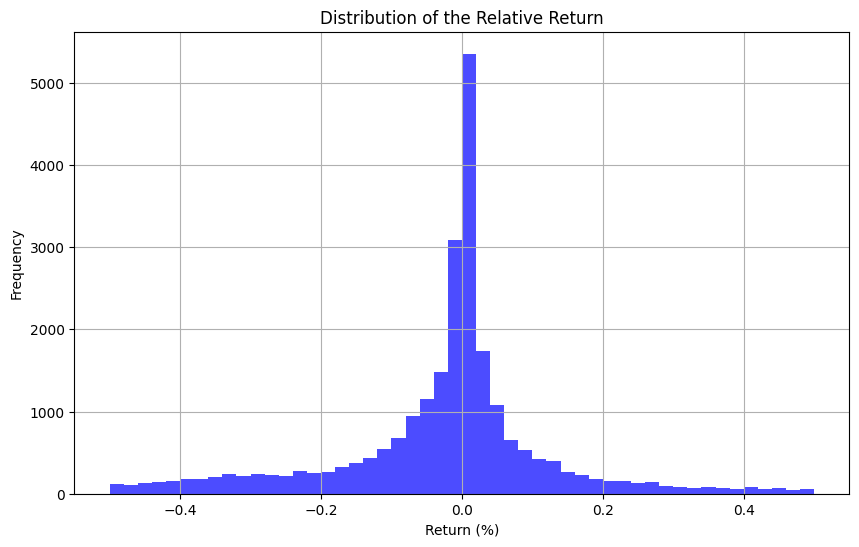

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(combined_df['relative_return'], bins=50, color='blue', alpha=0.7, range=(-0.5, 0.5))
plt.title('Distribution of the Relative Return')
plt.xlabel('Return (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

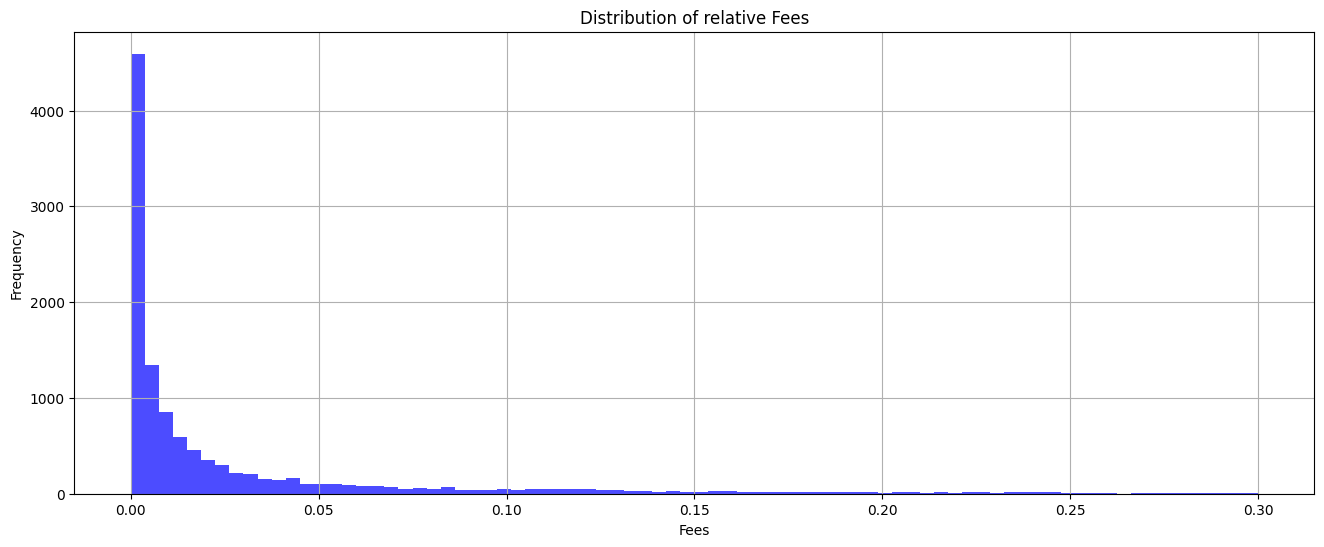

In [ ]:
plt.figure(figsize=(16, 6))
plt.hist(combined_df['IL_fees'], bins=80, color='blue', alpha=0.7, range=(0, 0.3))
plt.title('Distribution of relative Fees')
plt.xlabel('Fees')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd

# Assuming risky_combined_df is your DataFrame and the timestamp is in a column named 'timestamp'

# Convert Unix epoch timestamps to datetime
risky_combined_df['timestamp'] = pd.to_datetime(risky_combined_df['event_timestamp'], unit='s')

risky_combined_df['price_ratio'] = risky_combined_df['price_0'] / risky_combined_df['price_1']

table = risky_combined_df[['timestamp', 'price_0', 'price_1', 'price_ratio', 'IL_final']]

# Display the table
print(table.head(100))  # Display the first 10 rows for inspection

table.describe()


             timestamp  price_0    price_1  price_ratio  IL_final
0  2021-05-16 01:57:28      1.0  3827.8815     0.000261   -0.0002
1  2023-08-02 05:53:59      1.0  1863.8805     0.000537   -0.1364
2  2022-07-17 12:54:22      1.0  1354.8161     0.000738   -0.9646
3  2022-05-16 20:53:21      1.0  2026.4850     0.000493   -0.3775
4  2023-11-26 04:24:59      1.0  2078.3868     0.000481   -0.1672
..                 ...      ...        ...          ...       ...
95 2024-03-29 01:45:47      1.0  3572.5898     0.000280   -0.2586
96 2021-08-05 21:41:07      1.0  2819.5265     0.000355   -0.0304
97 2022-05-09 11:05:04      1.0  2401.2213     0.000416   -0.0073
98 2021-08-06 18:11:34      1.0  2918.8317     0.000343   -0.0642
99 2022-05-08 17:11:49      1.0  2523.2583     0.000396   -0.0069

[100 rows x 5 columns]


,timestamp,price_0,price_1,price_ratio,IL_final
count,751,751.000000,751.000000,751.000000,751.000000
mean,2022-09-10 04:20:13.002663168,12540.644302,2080.969774,5.764662,-0.102072
min,2021-05-10 15:56:20,1.000000,949.786600,0.000231,-0.992300
25%,2022-05-13 15:23:19.500000,1.000000,1538.017750,0.000555,-0.096350
50%,2022-06-26 05:26:27,1.000000,1812.457200,0.000844,-0.018600
75%,2022-12-03 22:27:47,25309.811850,2531.092750,13.939879,-0.003150
max,2024-04-13 22:38:47,69196.234600,4796.360700,20.292800,0.000000
std,NaN,17980.016540,846.983947,7.477623,0.184669


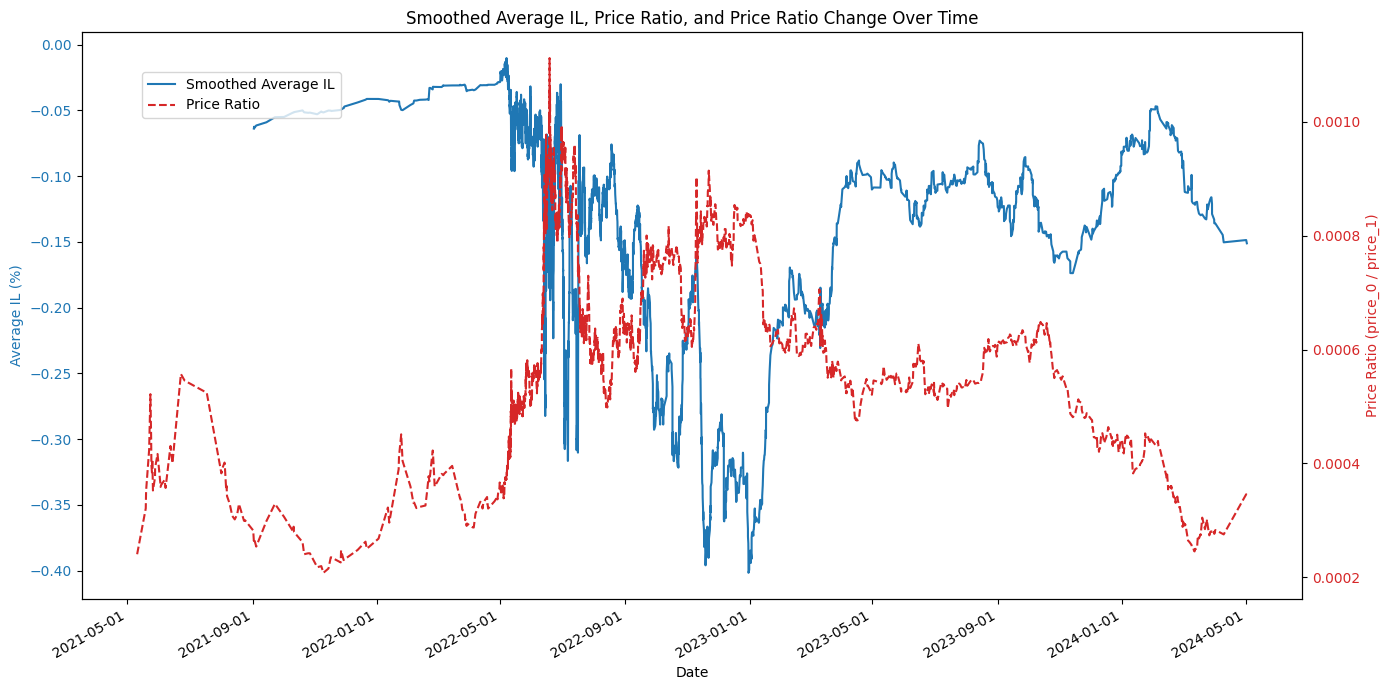

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Assuming pool_dataframes is your dictionary containing the dataframes
usdc_weth_df = pool_dataframes['USDC_WETH_3000'].copy()  # Make a copy of the DataFrame

# Convert Unix epoch timestamps to datetime
usdc_weth_df.loc[:, 'timestamp'] = pd.to_datetime(usdc_weth_df['event_timestamp'], unit='s')

# Group by timestamp and calculate the average IL and price ratio
grouped = usdc_weth_df.groupby('timestamp').agg({'IL_final': 'mean', 'price_0': 'mean', 'price_1': 'mean'}).reset_index()
grouped['price_ratio'] = grouped['price_0'] / grouped['price_1']

# Calculate the rolling mean for the average IL
grouped['IL_final_smooth'] = grouped['IL_final'].rolling(window=50).mean()  # Adjust window size as needed

# Calculate the percentage change of the price ratio
#grouped['price_ratio_change'] = grouped['price_ratio'].pct_change()

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot smoothed average IL
ax1.set_xlabel('Date')
ax1.set_ylabel('Average IL (%)', color='tab:blue')
ax1.plot(grouped['timestamp'], grouped['IL_final_smooth'], color='tab:blue', label='Smoothed Average IL')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Format the x-axis for dates
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()

# Create a second y-axis for the price ratio
ax2 = ax1.twinx()
ax2.set_ylabel('Price Ratio (price_0 / price_1)', color='tab:red')
ax2.plot(grouped['timestamp'], grouped['price_ratio'], color='tab:red', label='Price Ratio', linestyle='--')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add a title and legend
plt.title('Smoothed Average IL, Price Ratio, and Price Ratio Change Over Time')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Show the plot
plt.show()

#price chart umdrehen


Correlation coefficient between smoothed average IL and price ratio: -0.54


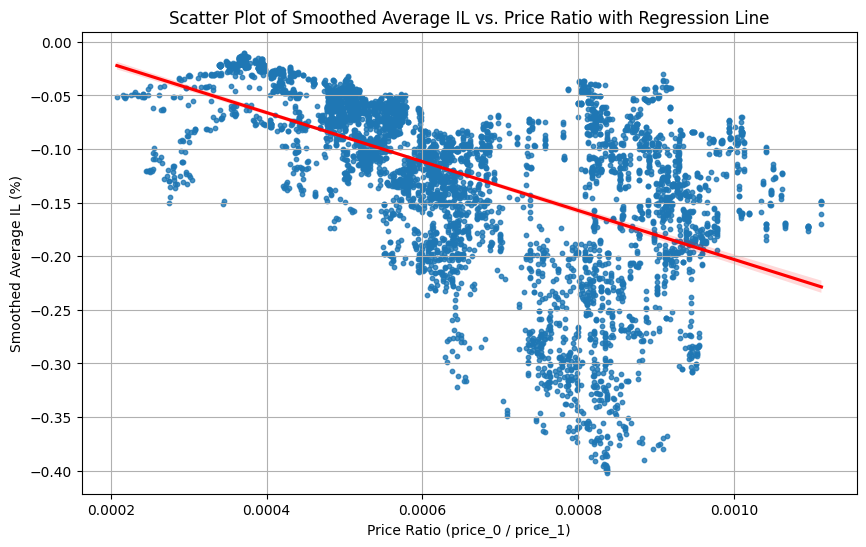

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates

# Assuming pool_dataframes is your dictionary containing the dataframes
usdc_weth_df = pool_dataframes['USDC_WETH_3000'].copy()  # Make a copy of the DataFrame

# Convert Unix epoch timestamps to datetime
usdc_weth_df.loc[:, 'timestamp'] = pd.to_datetime(usdc_weth_df['event_timestamp'], unit='s')

# Group by timestamp and calculate the average IL and price ratio
grouped = usdc_weth_df.groupby('timestamp').agg({'IL_final': 'mean', 'price_0': 'mean', 'price_1': 'mean'}).reset_index()
grouped['price_ratio'] = grouped['price_0'] / grouped['price_1']

# Calculate the rolling mean for the average IL
grouped['IL_final_smooth'] = grouped['IL_final'].rolling(window=50).mean()  # Adjust window size as needed

# Calculate the correlation coefficient
correlation = grouped[['IL_final_smooth', 'price_ratio']].corr().iloc[0, 1]
print(f"Correlation coefficient between smoothed average IL and price ratio: {correlation:.2f}")

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='price_ratio', y='IL_final_smooth', data=grouped, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.xlabel('Price Ratio (price_0 / price_1)')
plt.ylabel('Smoothed Average IL (%)')
plt.title('Scatter Plot of Smoothed Average IL vs. Price Ratio with Regression Line')
plt.grid(True)
plt.show()


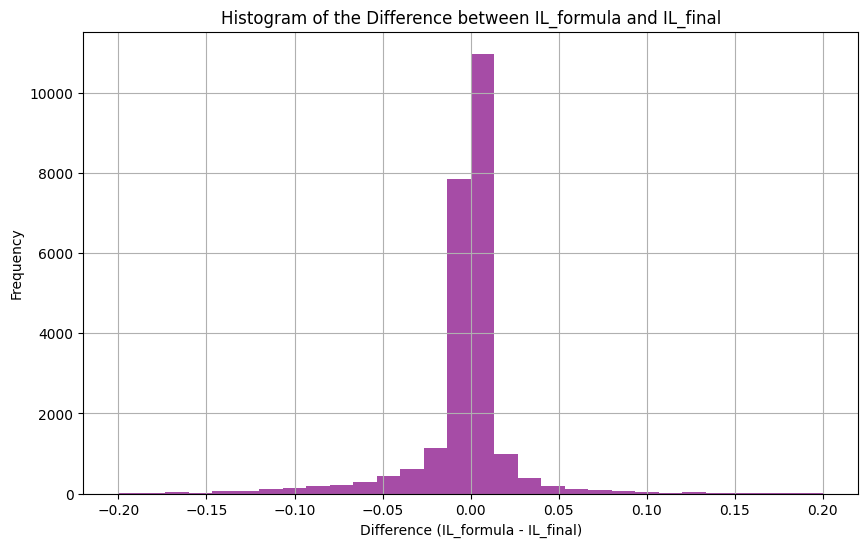

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming risky_combined_df is your DataFrame

# Calculate the difference between IL_formula and IL_final
risky_combined_df['IL_difference'] = risky_combined_df['IL_formula'] - risky_combined_df['IL_initial']

# Plotting the difference as a histogram
plt.figure(figsize=(10, 6))
plt.hist(risky_combined_df['IL_difference'], bins=30, color='purple', alpha=0.7, range=(-0.2, 0.2))
plt.xlabel('Difference (IL_formula - IL_final)')
plt.ylabel('Frequency')
plt.title('Histogram of the Difference between IL_formula and IL_final')
plt.grid(True)
plt.show()

# density


In [ ]:
import pandas as pd
from tabulate import tabulate

# Assuming risky_combined_df is your DataFrame

# Calculate the difference between IL_formula and IL_final
risky_combined_df['IL_difference'] = risky_combined_df['IL_formula'] - risky_combined_df['IL_initial']

# Filter the DataFrame where the difference is more than 0.2
large_difference_df = risky_combined_df[risky_combined_df['IL_difference'] > 0.2]

# Select relevant columns for display
table = large_difference_df[['IL_formula', 'IL_initial', 'IL_difference', 'event_amountUSD', 'initialValue', 'finalValue']]

# Display the table in a readable format using tabulate
print(tabulate(table, headers='keys', tablefmt='psql', showindex=False))


+--------------+--------------+-----------------+-------------------+------------------+------------------+
|   IL_formula |   IL_initial |   IL_difference |   event_amountUSD |     initialValue |       finalValue |
|--------------+--------------+-----------------+-------------------+------------------+------------------|
|    -0.306724 |    -0.521777 |        0.215053 |       1.19264e+06 | 978138           |      1.19264e+06 |
|    -0.431849 |    -1.03811  |        0.606258 |   61781.3         |  44757.2         |  61781.3         |
|    -0.023078 |    -0.318701 |        0.295623 |      74.6418      |    191.897       |     74.6418      |
|    -0.035628 |    -0.256162 |        0.220534 |    4185.21        |  10357.5         |   4222.92        |
|    -0.162411 |    -0.670381 |        0.50797  |       1.47304e+06 |      1.10426e+06 |      1.47304e+06 |
|    -0.162411 |    -0.670381 |        0.50797  |       1.47304e+06 |      1.10426e+06 |      1.47304e+06 |
|    -0.002883 |    -0.21790

Our sample includes transactions from a timespan of 34 months, starting from June 1st 2021 until April 1st 2024. Since Uniswap was launched on May 5 2021 on the Ethereum mainnet, there is only limited data available. The sample only considers liquidity positions that were closed during that interval. The relatively long timespan was chosen to even out the temporary effects of market cycles, that also affect the volume of Uniswap v3.

In [ ]:
ZERO = 0
Q128 = 2 ** 128
Q256 = 2 ** 256

def subIn256(x, y):
    difference = x - y
    if difference < ZERO:
        return Q256 + difference
    else:
        return difference

def toBigNumber(value):
    return int(value)  # Convert string or number to Python integer, in case large number is in strign format

def getFees(feeGrowthGlobal0, feeGrowthGlobal1, feeGrowth0Low, feeGrowth0Hi, feeGrowthInside0, feeGrowth1Low, feeGrowth1Hi, feeGrowthInside1, liquidity, decimals0, decimals1, tickLower, tickUpper, tickCurrent):
    feeGrowthGlobal_0 = toBigNumber(feeGrowthGlobal0)
    feeGrowthGlobal_1 = toBigNumber(feeGrowthGlobal1)
    tickLowerFeeGrowthOutside_0 = toBigNumber(feeGrowth0Low)
    tickLowerFeeGrowthOutside_1 = toBigNumber(feeGrowth1Low)
    tickUpperFeeGrowthOutside_0 = toBigNumber(feeGrowth0Hi)
    tickUpperFeeGrowthOutside_1 = toBigNumber(feeGrowth1Hi)
    tickLowerFeeGrowthBelow_0 = ZERO
    tickLowerFeeGrowthBelow_1 = ZERO
    tickUpperFeeGrowthAbove_0 = ZERO
    tickUpperFeeGrowthAbove_1 = ZERO

    if tickCurrent >= tickUpper:
        tickUpperFeeGrowthAbove_0 = subIn256(feeGrowthGlobal_0, tickUpperFeeGrowthOutside_0)
        tickUpperFeeGrowthAbove_1 = subIn256(feeGrowthGlobal_1, tickUpperFeeGrowthOutside_1)
    else:
        tickUpperFeeGrowthAbove_0 = tickUpperFeeGrowthOutside_0
        tickUpperFeeGrowthAbove_1 = tickUpperFeeGrowthOutside_1

    if tickCurrent >= tickLower:
        tickLowerFeeGrowthBelow_0 = tickLowerFeeGrowthOutside_0
        tickLowerFeeGrowthBelow_1 = tickLowerFeeGrowthOutside_1
    else:
        tickLowerFeeGrowthBelow_0 = subIn256(feeGrowthGlobal_0, tickLowerFeeGrowthOutside_0)
        tickLowerFeeGrowthBelow_1 = subIn256(feeGrowthGlobal_1, tickLowerFeeGrowthOutside_1)

    fr_t1_0 = subIn256(subIn256(feeGrowthGlobal_0, tickLowerFeeGrowthBelow_0), tickUpperFeeGrowthAbove_0)
    fr_t1_1 = subIn256(subIn256(feeGrowthGlobal_1, tickLowerFeeGrowthBelow_1), tickUpperFeeGrowthAbove_1)
    feeGrowthInsideLast_0 = toBigNumber(feeGrowthInside0)
    feeGrowthInsideLast_1 = toBigNumber(feeGrowthInside1)

    uncollectedFees_0 = (liquidity * subIn256(fr_t1_0, feeGrowthInsideLast_0)) // Q128
    uncollectedFees_1 = (liquidity * subIn256(fr_t1_1, feeGrowthInsideLast_1)) // Q128

    uncollectedFeesAdjusted_0 = uncollectedFees_0 / (10 ** decimals0)
    uncollectedFeesAdjusted_1 = uncollectedFees_1 / (10 ** decimals1)
    print(f"Amount fees token 0 in lowest decimal: {int(uncollectedFees_0)}")
    print(f"Amount fees token 1 in lowest decimal: {int(uncollectedFees_1)}")
    print(f"Amount fees token 0 Human format: {uncollectedFeesAdjusted_0:.{decimals0}f}")
    print(f"Amount fees token 1 Human format: {uncollectedFeesAdjusted_1:.{decimals1}f}")


In [ ]:
getFees(3094836483914812667943230173936420,1,37180414779992829129391081655145,233371140530963296710329726203514,0,1,1,1,10860507277202,6,6,192180,193380,201780)
getFees(1598689279610056278300511697452980233550428,3435711821068543428641395387486415,828485853430476009282010998184629866963795,168474001916454882792751774532376246302129,599406432805413676403104389099663458397584,1207675746724748089633601970657256,633890610051325028869533762979989,1588710658195404578212538675916747,1455242849752042,18,6,200340,195420,196082)
getFees()

Amount fees token 0 in lowest decimal: 6261655
Amount fees token 1 in lowest decimal: 3695639122248373304231208116609338612196379944026111
Amount fees token 0 Human format: 6.261655
Amount fees token 1 Human format: 3695639122248373590578266900963621657483673600.000000
Amount fees token 0 in lowest decimal: 495193481358396479108080074813186106532318883319618272
Amount fees token 1 in lowest decimal: 495193481358396479108080074813186111669065693812072227
Amount fees token 0 Human format: 495193481358396475439740762330234880.000000000000000000
Amount fees token 1 Human format: 495193481358396497867848624699518333549748944896.000000


Code for python Async Requests (API Calls)

In [ ]:

class LiquidityProvider:
    def __init__(self, address):
        """
        Initializes a new LiquidityProvider instance.

        Parameters:
        address (str): The Ethereum address of the liquidity provider.
        """
        self.address = address
        self.positions = []

    def add_position(self, position):
        """
        Adds a new position to the liquidity provider's list of positions.

        Parameters:
        position (Position): The position to be added to this provider.
        """
        self.positions.append(position)
        position.provider = self  # Establish the reverse link from Position to LiquidityProvider

    def get_positions(self):
        """
        Returns a list of all positions for this liquidity provider.
        """
        return self.positions

    def __str__(self):
        """
        Returns a string representation of the LiquidityProvider object.
        """
        return f"Liquidity Provider Address: {self.address}"

class Event:

    def __init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, timestamp, liquidity, amount0, amount1, amountUSD):
        """
        Initializes a new Event instance.

        Parameters:
        block_number (int): The block number at which the event occurred.
        amount (float): The amount of liquidity involved in the event.
        """
        self.blocknumber = blocknumber
        self.collectedFeesToken0 = collectedFeesToken0
        self.collectedFeesToken1 = collectedFeesToken1
        self.depositedToken0 = depositedToken0
        self.depositedToken1 = depositedToken1
        self.feeGrowthInside0LastX128 = feeGrowthInside0LastX128
        self.feeGrowthInside1LastX128 = feeGrowthInside1LastX128
        self.id = id
        self.withdrawnToken0 = withdrawnToken0
        self.withdrawnToken1 = withdrawnToken1
        self.timestamp = timestamp
        self.liquidity = liquidity
        self.amount0 = amount0
        self.amount1 = amount1
        self.amountUSD = amountUSD
        self.tokenPrice0 = 0.5 * amountUSD / amount0
        self.tokenPrice1 = 0.5 * amountUSD / amount1



    def __str__(self):
        """
        Return a basic representation of the event, should be overridden by subclasses.
        """
        return f"Event at Block {self.block_number}, Amount: {self.amount}"

class Mint(Event):
    def __init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, amount, timestamp, liquidity, amount0, amount1, amountUSD):
        super().__init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, amount, timestamp, liquidity, amount0, amount1, amountUSD):
        self.isInitialMint = False
        self.amount = amount

    def __str__(self):
        return f"Mint: Block {self.block_number}, Amount: {self.amount}"

class Burn(Event):
    def __init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, amount, timestamp, liquidity, amount0, amount1, amountUSD):
        super().__init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, amount, timestamp, liquidity, amount0, amount1, amountUSD):
        self.isFinalBurn = False
        self.amount = amount

    def __str__(self):
        return f"Burn: Block {self.block_number}, Amount: {self.amount}"
    
class Collect(Event):
    def __init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, timestamp, liquidity, amount0, amount1, amountUSD):
        super().__init__(self, blocknumber, collectedFeesToken0, collectedFeesToken1, depositedToken0, depositedToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, id, withdrawnToken0, withdrawnToken1, timestamp, liquidity, amount0, amount1, amountUSD):

    def __str__(self):
        return f"Collect: Block {self.block_number}"
    
class Tick:
    def __init__(self, idx, price0, price1, feeGrowthOutside0X128, feeGrowthOutside1X128):
        """
        Initializes a new Tick instance.

        Parameters:
        price0 (float): The price of token0 in this tick.
        price1 (float): The price of token1 in this tick.
        feeGrowthOutside0X128 (int): The fee growth outside of this tick for token0.
        feeGrowthOutside1X128 (int): The fee growth outside of this tick for token1.
        """
        self.idx = idx
        self.price0 = price0
        self.price1 = price1
        self.feeGrowthOutside0X128 = feeGrowthOutside0X128
        self.feeGrowthOutside1X128 = feeGrowthOutside1X128

    def __str__(self):
        return f"Tick: {self.idx}"


class Position:
    def __init__(self, id, liquidity, owner, pool, amountCollectedUSD, amountDepositedUSD, amountWithdrawnUSD, collectedFeesToken0, collectedFeesToken1, collectedToken0, collectedToken1, initialDepositToken0, initialDepositToken1, feeGrowthInside0LastX128, feeGrowthInside1LastX128, tickLower, tickUpper, withdrawnToken0, withdrawnToken1):
        """
        Initializes a new Position instance.

        Parameters:
        provider (LiquidityProvider): The liquidity provider associated with this position.
        events (list of Event): A list of events associated with this position.
        """
        self.id = id
        self.liquidity = liquidity
        self.owner = owner
        self.pool = pool #pass Pool object, not in df
        self.token1 = pool.token1
        self.token0 = pool.token0
        self.amountCollectedUSD = amountCollectedUSD
        self.amountDepositedUSD = amountDepositedUSD
        self.amountWithdrawnUSD = amountWithdrawnUSD
        self.collectedFeesToken0 = collectedFeesToken0
        self.collectedFeesToken1 = collectedFeesToken1
        self.collectedToken0 = collectedToken0
        self.collectedToken1 = collectedToken1
        self.initialDepositToken0 = initialDepositToken0 # depositedToken= in TheGraph
        self.initialDepositToken1 = initialDepositToken1
        self.feeGrowthInside0LastX128 = feeGrowthInside0LastX128
        self.feeGrowthInside1LastX128 = feeGrowthInside1LastX128    
        self.tickLower = tickLower
        self.tickUpper = tickUpper
        self.withdrawnToken0 = withdrawnToken0
        self.withdrawnToken1 = withdrawnToken1
        self.events = []

    def add_event(self, event):
        """
        Adds a new event to the position's list of events.

        Parameters:
        event (Event): The event to be added to this position.
        """
        self.events.append(event)
        event.position = self  # Establish the reverse link from Event to Position
        self.events.sort(key=lambda x: x.block_number)

    def getHODLvalue(self, price0, price1):
        value = self.events.amount0 * price0 + self.events.amount1 * price1
        return value
    
    def getFinalHODLvalue(self):
        # get the last mint event and conmpute the value of the position at that time
        mint_event = max([event for event in self.events if isinstance(event, Mint)], key=lambda event: event.block_number)
        burn_event = max([event for event in self.events if isinstance(event, Burn)], key=lambda event: event.block_number)
        return mint_event.amount0 * burn_event.tokenPrice0 + burn_event.tokenPrice1 * mint_event.amount1
        

    def compute_balances(self):
        """
        Computes the current(remaining) liquidity for the position based on the events.
        """
        self.currentLiquidity = 0
        for event in self.events:
            if isinstance(event, Mint):
                self.currentLiquidity += event.liquidity
            elif isinstance(event, Burn):
                self.currentLiquidity -= event.liquidity 

    def compute_IL(self):
        """
        Computes the impermanent loss for the position based on the events.
        """
        self.IL = 0
        for event in self.events:
            if isinstance(event, Mint):
                self.IL += event.liquidity
            elif isinstance(event, Burn):
                self.IL -= event.liquidity

    def add_liquidity_provider(self, provider):
        """
        Adds a new liquidity provider to the position.

        Parameters:
        provider (LiquidityProvider): The liquidity provider to be added to this position.
        """
        self.provider = provider # Establish the link from Position to LiquidityProvider

    def get_events(self):
        """
        Returns a list of all events for this position.
        """
        return self.events
    
    def get_provider(self):
        """
        Returns the liquidity provider associated with this position.
        """
        return self.provider

    def __str__(self):
        events_str = "\n".join([str(event) for event in self.events])
        return f"Position for {self.provider}\nEvents:\n{events_str}"


class PoolSample:
    def __init__(self, pool: Pool):
        self.pool = pool
        self.positions = []

    def add_position(self, position:Position):
        self.positions.append(position)
        position.pool = self
